In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv(r'C:\Users\tanvi\Documents\Tanvi_Jain_A1\laptop_price_task\data\Laptop Price.csv')  

def manual_label_encode(series):
    unique_vals = series.unique()
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    return series.map(mapping), mapping

for col in ['Company', 'TypeName', 'OpSys']:
    df[col], mapping = manual_label_encode(df[col])

df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)
df['IPS'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

df['X_res'] = df['ScreenResolution'].str.split('x').str[0].str.extract(r'(\d+)').astype(int)
df['Y_res'] = df['ScreenResolution'].str.split('x').str[1].str.extract(r'(\d+)').astype(int)

df.drop('ScreenResolution', axis=1, inplace=True)

df['Cpu_brand'] = df['Cpu'].apply(lambda x: x.split()[0])
df['Cpu_type'] = df['Cpu'].apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'Other')

df['Cpu_speed'] = df['Cpu'].str.extract(r'(\d+\.?\d*)GHz')[0].astype(float).fillna(0)

df['Cpu_brand'], _ = manual_label_encode(df['Cpu_brand'])
df['Cpu_type'], _ = manual_label_encode(df['Cpu_type'])

df.drop('Cpu', axis=1, inplace=True)

df['Gpu_brand'] = df['Gpu'].apply(lambda x: x.split()[0])
df['Gpu_brand'], _ = manual_label_encode(df['Gpu_brand'])
df.drop('Gpu', axis=1, inplace=True)

def parse_memory(mem_str):
    ssd = hdd = 0
    mem_str = mem_str.replace('GB', ' GB').replace('TB', ' TB')
    parts = mem_str.split('+')
    
    for part in parts:
        part = part.strip()
        # SSD
        if 'SSD' in part:
            size_str = part.split()[0]
            if 'TB' in part:
                size = int(float(size_str) * 1000)
            else:
                size = int(float(size_str))
            ssd = size
        # HDD
        elif 'HDD' in part:
            size_str = part.split()[0]
            if 'TB' in part:
                size = int(float(size_str) * 1000)
            else:
                size = int(float(size_str))
            hdd = size
    return pd.Series([ssd, hdd])

df[['SSD', 'HDD']] = df['Memory'].apply(parse_memory)
df.drop('Memory', axis=1, inplace=True)

df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)


df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)


print(df.head())
print("\nData types:\n", df.dtypes)


   Company  TypeName  Inches  Ram  OpSys  Weight       Price  Touchscreen  \
0        0         0    15.6    8      0    2.50   52161.120            0   
1        1         0    14.0    4      1    1.50   14811.840            0   
2        2         0    15.6    4      0    2.20   14646.672            0   
3        3         1    14.0   16      1    1.42  150462.720            1   
4        0         0    15.6    4      1    2.40   23976.000            0   

   IPS  X_res  Y_res  Cpu_brand  Cpu_type  Cpu_speed  Gpu_brand   SSD  HDD  
0    0   1920   1080          0         0        2.8          0   256    0  
1    0   1366    768          0         1        1.1          1     0    0  
2    0   1366    768          0         1        1.6          1     0  500  
3    0   2560   1440          0         0        2.7          1  1000    0  
4    0   1366    768          0         0        2.0          1     0  500  

Data types:
 Company          int64
TypeName         int64
Inches         

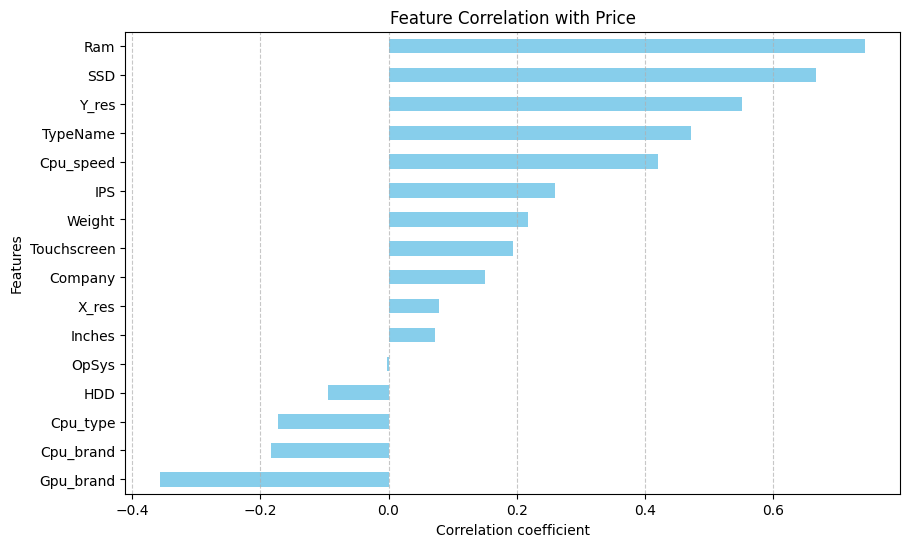

In [3]:
import matplotlib.pyplot as plt


correlations = df.corr()['Price'].sort_values()


plt.figure(figsize=(10,6))
correlations.drop('Price').plot(kind='barh', color='skyblue')
plt.title('Feature Correlation with Price')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


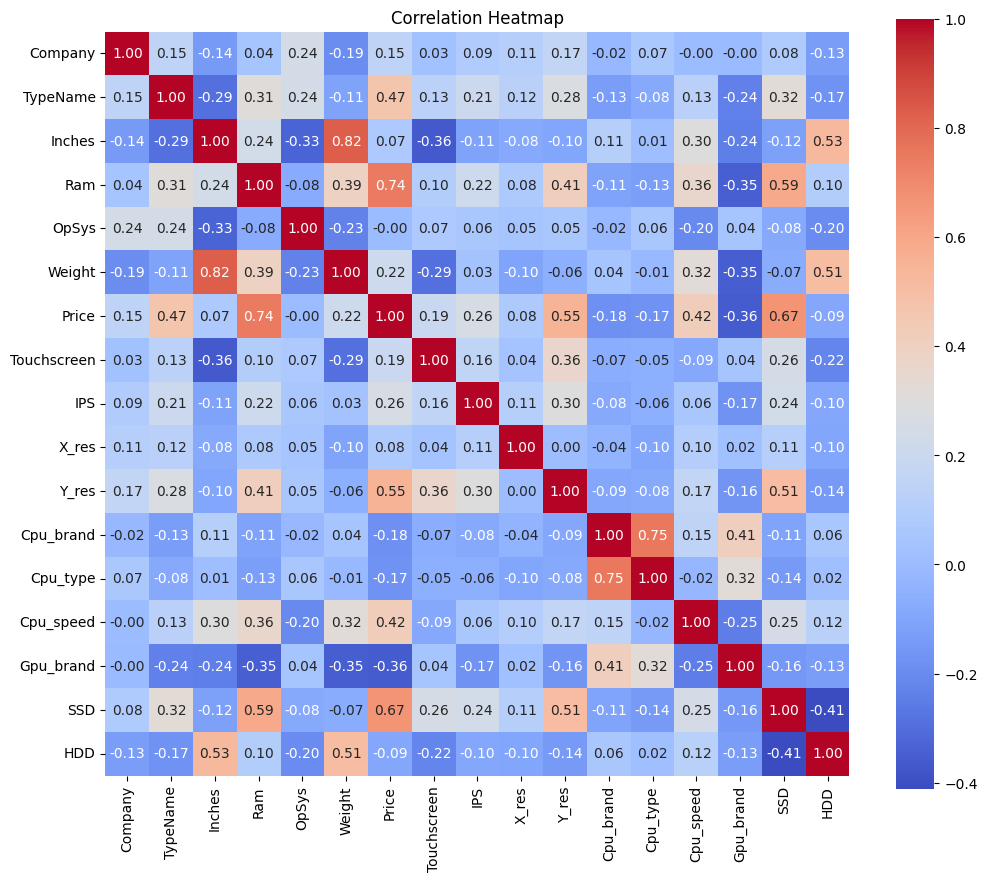

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()


plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.show()



Intercept: 13774.58, Slope: 5519.90


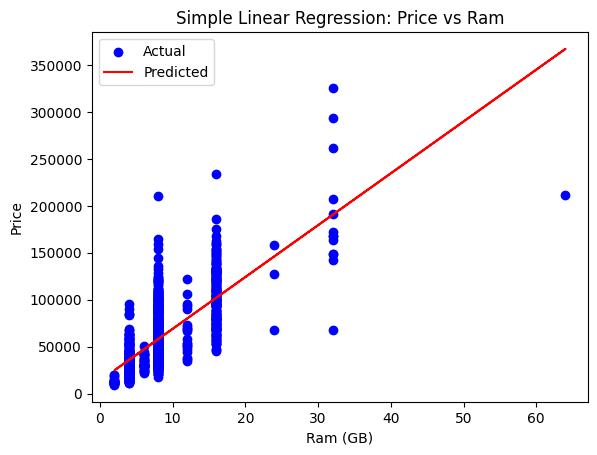

In [5]:
import numpy as np
import matplotlib.pyplot as plt

X = df['Ram'].values  
y = df['Price'].values  


X_b = np.c_[np.ones((len(X), 1)), X]  


theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept = theta[0]
slope = theta[1]
print(f"Intercept: {intercept:.2f}, Slope: {slope:.2f}")


y_pred = X_b.dot(theta)

plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('Ram (GB)')
plt.ylabel('Price')
plt.title('Simple Linear Regression: Price vs Ram')
plt.legend()
plt.show()


In [6]:

X = df.drop('Price', axis=1).values
y = df['Price'].values


X_b = np.c_[np.ones((len(X), 1)), X]


theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print("Coefficients for all features:")
for col, coef in zip(['Intercept'] + list(df.drop('Price', axis=1).columns), theta):
    print(f"{col}: {coef:.2f}")


Coefficients for all features:
Intercept: -42821.51
Company: 1069.34
TypeName: 5194.69
Inches: -220.92
Ram: 2570.37
OpSys: 925.94
Weight: 7419.30
Touchscreen: 5390.77
IPS: -201.77
X_res: -1.64
Y_res: 21.38
Cpu_brand: -22299.40
Cpu_type: 703.06
Cpu_speed: 13339.09
Gpu_brand: 78.16
SSD: 51.08
HDD: -1.71


In [7]:
import matplotlib.pyplot as plt
import numpy as np


X = df.drop('Price', axis=1).values
y = df['Price'].values

X_b = np.c_[np.ones((len(X), 1)), X]


theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

y_pred = X_b.dot(theta)

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)  # Perfect fit line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Multi-Feature Linear Regression: Actual vs Predicted Price')
plt.grid(True)
plt.show()


In [8]:
residuals = y - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()


In [9]:
import numpy as np


X = df.drop('Price', axis=1).values
y = df['Price'].values


X_b = np.c_[np.ones((len(X), 1)), X]


theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)


y_pred = X_b.dot(theta)

mse = np.mean((y - y_pred)**2)

rmse = np.sqrt(mse)

r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MSE: 360779926.26
RMSE: 18994.21
R²: 0.7427


In [10]:

y_log = np.log1p(df['Price'].values)  

theta_log = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_log)

y_log_pred = X_b.dot(theta_log)

y_pred_exp = np.expm1(y_log_pred)

mse_log = np.mean((df['Price'].values - y_pred_exp)**2)
rmse_log = np.sqrt(mse_log)
r2_log = 1 - np.sum((df['Price'].values - y_pred_exp)**2) / np.sum((df['Price'].values - np.mean(df['Price'].values))**2)

print(f"Log Regression -> MSE: {mse_log:.2f}, RMSE: {rmse_log:.2f}, R²: {r2_log:.4f}")


Log Regression -> MSE: 777913789.38, RMSE: 27891.11, R²: 0.4452


In [11]:
from itertools import combinations


df['ResArea'] = df['X_res'] * df['Y_res']


X_poly = df.drop('Price', axis=1).values
X_poly_b = np.c_[np.ones((len(X_poly), 1)), X_poly]


theta_poly = np.linalg.inv(X_poly_b.T.dot(X_poly_b)).dot(X_poly_b.T).dot(y)


y_poly_pred = X_poly_b.dot(theta_poly)


mse_poly = np.mean((y - y_poly_pred)**2)
rmse_poly = np.sqrt(mse_poly)
r2_poly = 1 - np.sum((y - y_poly_pred)**2) / np.sum((y - np.mean(y))**2)

print(f"Polynomial Regression -> MSE: {mse_poly:.2f}, RMSE: {rmse_poly:.2f}, R²: {r2_poly:.4f}")


Polynomial Regression -> MSE: 360187131.87, RMSE: 18978.60, R²: 0.7431


In [12]:
import numpy as np


X = df.drop('Price', axis=1).values
y = df['Price'].values


X_b = np.c_[np.ones((len(X), 1)), X]


alpha = 10 


I = np.eye(X_b.shape[1])
I[0,0] = 0  #


theta_ridge = np.linalg.inv(X_b.T.dot(X_b) + alpha * I).dot(X_b.T).dot(y)


y_ridge_pred = X_b.dot(theta_ridge)


mse_ridge = np.mean((y - y_ridge_pred)**2)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = 1 - np.sum((y - y_ridge_pred)**2) / np.sum((y - np.mean(y))**2)

print(f"Ridge Regression -> MSE: {mse_ridge:.2f}, RMSE: {rmse_ridge:.2f}, R²: {r2_ridge:.4f}")


Ridge Regression -> MSE: 361339144.16, RMSE: 19008.92, R²: 0.7423


In [13]:
import numpy as np


X = df.drop('Price', axis=1).values
y = df['Price'].values


X_b = np.c_[np.ones((len(X), 1)), X]

I = np.eye(X_b.shape[1])
I[0,0] = 0

alphas = [0, 10, 100, 1000, 5000]
results = []

for alpha in alphas:
    
    theta_ridge = np.linalg.inv(X_b.T.dot(X_b) + alpha * I).dot(X_b.T).dot(y)
    
    
    y_pred = X_b.dot(theta_ridge)
    
   
    mse = np.mean((y - y_pred)**2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
    
    results.append((alpha, mse, rmse, r2))


        

print(f"{'Alpha':>6} | {'MSE':>12} | {'RMSE':>10} | {'R²':>6}")
print("-"*45)
for alpha, mse, rmse, r2 in results:
    print(f"{alpha:6} | {mse:12.2f} | {rmse:10.2f} | {r2:6.4f}")


 Alpha |          MSE |       RMSE |     R²
---------------------------------------------
     0 | 360187131.87 |   18978.60 | 0.7431
    10 | 361339144.16 |   19008.92 | 0.7423
   100 | 370208288.17 |   19240.80 | 0.7360
  1000 | 397525206.63 |   19938.03 | 0.7165
  5000 | 438810822.12 |   20947.81 | 0.6870


In [14]:
df['Price_capped'] = df['Price'].clip(upper=200000)


In [15]:
import numpy as np


X = df.drop('Price', axis=1).values
y = df['Price'].values


X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std


X_b = np.c_[np.ones((len(X_scaled), 1)), X_scaled]
y_centered = y - np.mean(y)

alpha = 0.001  
max_iter = 1000
tol = 1e-4

theta = np.zeros(X_b.shape[1])


for iteration in range(max_iter):
    theta_old = theta.copy()
    for j in range(1, X_b.shape[1]):  
        residual = y_centered - X_b.dot(theta) + theta[j]*X_b[:,j]
        rho = np.dot(X_b[:,j], residual)
        
       
        if rho < -alpha/2:
            theta[j] = (rho + alpha/2) / np.sum(X_b[:,j]**2)
        elif rho > alpha/2:
            theta[j] = (rho - alpha/2) / np.sum(X_b[:,j]**2)
        else:
            theta[j] = 0
   
    if np.max(np.abs(theta - theta_old)) < tol:
        break


theta[0] = np.mean(y) - np.sum(theta[1:] * X_mean / X_std)


y_pred_lasso = X_b.dot(theta)

mse_lasso = np.mean((y - y_pred_lasso)**2)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = 1 - np.sum((y - y_pred_lasso)**2) / np.sum((y - np.mean(y))**2)

print(f"Lasso Regression -> MSE: {mse_lasso:.2f}, RMSE: {rmse_lasso:.2f}, R²: {r2_lasso:.4f}")


Lasso Regression -> MSE: 4065501081.12, RMSE: 63761.28, R²: -1.8995


In [16]:
import numpy as np

def ST(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(np.abs(x) - u, 0.0)

def cd_solver(X, y, alpha, max_iter=100):
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    R = y.copy()  
    lc = (X ** 2).sum(axis=0)  

    for t in range(max_iter):
        beta_old = beta.copy()
        for j in range(n_features):
            old = beta[j]
            beta[j] = ST(old + X[:, j].dot(R) / lc[j], alpha / lc[j])

          
            if old != beta[j]:
                R += (old - beta[j]) * X[:, j]

    
        if np.max(np.abs(beta - beta_old)) < 1e-6:
            break

    return beta

X = df.drop('Price', axis=1).values
y = df['Price'].values


X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

alpha_max = np.max(np.abs(X_scaled.T.dot(y)))
alpha = alpha_max / 2  
beta = cd_solver(X_scaled, y, alpha, max_iter=500)


intercept = np.mean(y) - np.sum(beta * X_mean / X_std)


y_pred_lasso = intercept + X_scaled.dot(beta)

mse_lasso = np.mean((y - y_pred_lasso)**2)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = 1 - np.sum((y - y_pred_lasso)**2) / np.sum((y - np.mean(y))**2)

print(f"Lasso Regression -> MSE: {mse_lasso:.2f}, RMSE: {rmse_lasso:.2f}, R²: {r2_lasso:.4f}")


Lasso Regression -> MSE: 1319423457.36, RMSE: 36323.87, R²: 0.0590


In [17]:
import numpy as np


X = df.drop('Price', axis=1).values
y = df['Price'].values.reshape(-1, 1)  
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]


theta = np.zeros((X_b.shape[1], 1))


learning_rate = 0.01
n_iterations = 5000

for iteration in range(n_iterations):
    gradients = 2/X_b.shape[0] * X_b.T.dot(X_b.dot(theta) - y)
    theta -= learning_rate * gradients


y_pred = X_b.dot(theta)


mse = np.mean((y - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

print(f"Gradient Descent OLS -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Gradient Descent OLS -> MSE: 21089689.54, RMSE: 4592.35, R²: 0.9850


In [18]:
import numpy as np


k = 5 
learning_rate = 0.01
n_iterations = 5000

X = df.drop('Price', axis=1).values
y = df['Price'].values.reshape(-1, 1)


np.random.seed(42)
indices = np.random.permutation(len(X))
fold_sizes = len(X) // k

mse_scores = []
rmse_scores = []
r2_scores = []

for i in range(k):
    
    val_idx = indices[i*fold_sizes:(i+1)*fold_sizes]
    train_idx = np.concatenate([indices[:i*fold_sizes], indices[(i+1)*fold_sizes:]])

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)
    X_train_scaled = (X_train - X_mean) / X_std
    X_val_scaled = (X_val - X_mean) / X_std

    
    X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_val_b = np.c_[np.ones((X_val_scaled.shape[0], 1)), X_val_scaled]

    theta = np.zeros((X_train_b.shape[1], 1))

    
    for iteration in range(n_iterations):
        gradients = 2/X_train_b.shape[0] * X_train_b.T.dot(X_train_b.dot(theta) - y_train)
        theta -= learning_rate * gradients

    
    y_val_pred = X_val_b.dot(theta)

    mse = np.mean((y_val - y_val_pred)**2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y_val - y_val_pred)**2) / np.sum((y_val - np.mean(y_val))**2)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    
    print(f"Fold {i+1} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


print("\nAverage across all folds:")
print(f"Average MSE: {np.mean(mse_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average R²: {np.mean(r2_scores):.4f}")



Fold 1 -> MSE: 6033989.65, RMSE: 2456.42, R²: 0.9954
Fold 2 -> MSE: 5006419.95, RMSE: 2237.50, R²: 0.9962
Fold 3 -> MSE: 59521119.39, RMSE: 7714.99, R²: 0.9577
Fold 4 -> MSE: 8126059.82, RMSE: 2850.62, R²: 0.9940
Fold 5 -> MSE: 42611407.56, RMSE: 6527.74, R²: 0.9740

Average across all folds:
Average MSE: 24259799.27
Average RMSE: 4357.46
Average R²: 0.9834


In [19]:
import numpy as np


np.random.seed(42)
indices = np.random.permutation(len(df))
train_size = int(0.8 * len(df))

train_idx = indices[:train_size]
test_idx = indices[train_size:]

X = df.drop('Price', axis=1).values
y = df['Price'].values.reshape(-1,1)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std  


In [20]:
k = 5
indices = np.arange(len(df))
np.random.shuffle(indices)
fold_sizes = len(df) // k
mse_scores = []

for i in range(k):
    test_idx = indices[i*fold_sizes:(i+1)*fold_sizes]
    train_idx = np.concatenate([indices[:i*fold_sizes], indices[(i+1)*fold_sizes:]])
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
   
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)
    X_train_scaled = (X_train - X_mean) / X_std
    X_test_scaled = (X_test - X_mean) / X_std
    
    
    X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
    
   
    theta = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)
    
    
    y_pred = X_test_b.dot(theta)
    
   
    mse_scores.append(np.mean((y_test - y_pred)**2))

print(f"Average MSE across {k} folds: {np.mean(mse_scores):.2f}")


Average MSE across 5 folds: 23346623.80


In [21]:
import numpy as np
import pandas as pd


df['ResArea'] = df['X_res'] * df['Y_res']         
df['Inches_Ram'] = df['Inches'] * df['Ram']      
df['Total_Storage'] = df['SSD'] + df['HDD']      




In [22]:

df['Price_log'] = np.log1p(df['Price'])  


In [23]:

features = df.drop(columns=['Price', 'Price_log'])
X = features.values
y_log = df['Price_log'].values.reshape(-1,1)


In [24]:

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std


X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]


In [25]:

theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_log)


y_log_pred = X_b.dot(theta)


y_pred = np.expm1(y_log_pred)


In [26]:

mse = np.mean((df['Price'].values - y_pred)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((df['Price'].values - y_pred)**2) / np.sum((df['Price'].values - np.mean(df['Price'].values))**2)

print(f"Linear Regression with Log-Target -> MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Linear Regression with Log-Target -> MSE: 8774977602.11
RMSE: 93674.85
R²: -7333.7669


In [27]:
import numpy as np
import pandas as pd


df['ResArea'] = df['X_res'] * df['Y_res']
df['Inches_Ram'] = df['Inches'] * df['Ram']
df['Total_Storage'] = df['SSD'] + df['HDD']


y_log = np.log1p(df['Price'].values).reshape(-1,1)


features = df.drop(columns=['Price', 'Price_log'] if 'Price_log' in df.columns else ['Price'])
X = features.values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std


X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]


alpha = 1000   
I = np.eye(X_b.shape[1])
I[0,0] = 0   

 
theta_ridge = np.linalg.inv(X_b.T.dot(X_b) + alpha * I).dot(X_b.T).dot(y_log)

y_log_pred = X_b.dot(theta_ridge)
y_pred = np.expm1(y_log_pred)  


y_pred = np.clip(y_pred, 0, df['Price'].max()*2)


mse = np.mean((df['Price'].values - y_pred.flatten())**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((df['Price'].values - y_pred.flatten())**2) / np.sum((df['Price'].values - np.mean(df['Price'].values))**2)

print(f"Ridge Regression with Log-Target -> MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


Ridge Regression with Log-Target -> MSE: 339969687.17
RMSE: 18438.27
R²: 0.7575


In [28]:
df = pd.read_csv(r'C:\Users\tanvi\Documents\Tanvi_Jain_A1\laptop_price_task\data\Laptop Price.csv') 

In [29]:
import pandas as pd
import re

def parse_screen_resolution(df, col="ScreenResolution", drop_original=False):
    """
    Parses a 'ScreenResolution' column into numeric resolution values and binary features.
    """
    
    features = {
        "IPS_panel": "IPS Panel",
        "Touchscreen": "Touchscreen",
        "Ultra_HD": "4K Ultra HD",
        "Full_HD": "Full HD",
        "Quad_HD_plus": "Quad HD\\+",
        "Retina_display": "Retina Display"
    }
    
    
    for f, pattern in features.items():
        df[f] = df[col].str.contains(pattern, case=False, regex=True).astype(int)
    
    
    resolution = df[col].str.extract(r"(\d{3,4})x(\d{3,4})")
    df["X_res"] = pd.to_numeric(resolution[0], errors="coerce")
    df["Y_res"] = pd.to_numeric(resolution[1], errors="coerce")
    
    
    df["Resolution_area"] = df["X_res"] * df["Y_res"]
    df["Aspect_ratio"] = (df["X_res"] / df["Y_res"]).round(2)
    
    
    if drop_original:
        df = df.drop(columns=[col])
    
    return df


df_out = parse_screen_resolution(df, drop_original=False)
print(df_out)

     Company            TypeName  Inches       ScreenResolution  \
0       Acer            Notebook    15.6      Full HD 1920x1080   
1       Asus            Notebook    14.0               1366x768   
2       Dell            Notebook    15.6               1366x768   
3     Lenovo  2 in 1 Convertible    14.0  Touchscreen 2560x1440   
4       Acer            Notebook    15.6               1366x768   
...      ...                 ...     ...                    ...   
1167    Dell           Ultrabook    14.0      Full HD 1920x1080   
1168    Dell              Gaming    15.6      Full HD 1920x1080   
1169  Lenovo            Notebook    17.3               1600x900   
1170  Lenovo              Gaming    15.6      Full HD 1920x1080   
1171      HP           Ultrabook    12.5      Full HD 1920x1080   

                                       Cpu   Ram              Memory  \
0              Intel Core i7 7700HQ 2.8GHz   8GB           256GB SSD   
1     Intel Celeron Dual Core N3350 1.1GHz   4GB  3

In [30]:
import pandas as pd
import re

def parse_cpu(df, col="Cpu", drop_original=False):
    
    df["CPU_brand"] = df[col].str.extract(r"^(Intel|AMD|Samsung)", expand=False)
    
   
    df["CPU_family"] = df[col].str.extract(
        r"(Core\s+i\d|Pentium|Celeron|Atom|Xeon|Ryzen|A\d+-Series|E-Series|FX|Cortex)",
        expand=False
    )
    
    df["CPU_suffix"] = df[col].str.extract(r"\s([A-Z]{1,2}\d{0,2}|N)\d*", expand=False)
    
   
    df["CPU_speed_GHz"] = df[col].str.extract(r"([\d\.]+)GHz", expand=False).astype(float)
    
    
    if drop_original:
        df = df.drop(columns=[col])
    
    return df
df_parsed = parse_cpu(df, drop_original=True)
print(df_parsed)

     Company            TypeName  Inches       ScreenResolution   Ram  \
0       Acer            Notebook    15.6      Full HD 1920x1080   8GB   
1       Asus            Notebook    14.0               1366x768   4GB   
2       Dell            Notebook    15.6               1366x768   4GB   
3     Lenovo  2 in 1 Convertible    14.0  Touchscreen 2560x1440  16GB   
4       Acer            Notebook    15.6               1366x768   4GB   
...      ...                 ...     ...                    ...   ...   
1167    Dell           Ultrabook    14.0      Full HD 1920x1080   8GB   
1168    Dell              Gaming    15.6      Full HD 1920x1080   8GB   
1169  Lenovo            Notebook    17.3               1600x900   4GB   
1170  Lenovo              Gaming    15.6      Full HD 1920x1080  16GB   
1171      HP           Ultrabook    12.5      Full HD 1920x1080   4GB   

                  Memory                         Gpu       OpSys  Weight  \
0              256GB SSD  Nvidia GeForce GTX 10

In [31]:
import pandas as pd
import re

def parse_memory(df, col="Memory", drop_original=False):
    """
    Parses a 'Memory' column into structured numeric features.
    Extracts capacity (in GB) for each storage type: HDD, SSD, Flash, Hybrid.
    
    Args:
        df (pd.DataFrame): Input dataframe with a Memory column.
        col (str): Column name containing memory strings.
        drop_original (bool): If True, drop the original column.
    
    Returns:
        pd.DataFrame
    """
    
   
    df["HDD_GB"] = 0
    df["SSD_GB"] = 0
    df["Flash_GB"] = 0
    df["Hybrid_GB"] = 0

   
    def size_to_gb(size_str):
        size_str = size_str.strip()
        if "TB" in size_str:
            return float(size_str.replace("TB","")) * 1000
        elif "GB" in size_str:
            return float(size_str.replace("GB",""))
        else:
            return 0
    
    
    for i, entry in df[col].items():
        if pd.isna(entry):
            continue
        parts = [p.strip() for p in entry.split("+")]  
        for p in parts:
            match = re.match(r"([\d\.]+)(TB|GB)", p)
            if not match:
                continue
            size_gb = size_to_gb(match.group(0))
            
            if "HDD" in p:
                df.at[i, "HDD_GB"] += size_gb
            elif "SSD" in p:
                df.at[i, "SSD_GB"] += size_gb
            elif "Flash" in p:
                df.at[i, "Flash_GB"] += size_gb
            elif "Hybrid" in p:
                df.at[i, "Hybrid_GB"] += size_gb
    
    
    if drop_original:
        df = df.drop(columns=[col])
    
    return df
df_parsed = parse_memory(df, drop_original=True)
print(df_parsed)

     Company            TypeName  Inches       ScreenResolution  \
0       Acer            Notebook    15.6      Full HD 1920x1080   
1       Asus            Notebook    14.0               1366x768   
2       Dell            Notebook    15.6               1366x768   
3     Lenovo  2 in 1 Convertible    14.0  Touchscreen 2560x1440   
4       Acer            Notebook    15.6               1366x768   
...      ...                 ...     ...                    ...   
1167    Dell           Ultrabook    14.0      Full HD 1920x1080   
1168    Dell              Gaming    15.6      Full HD 1920x1080   
1169  Lenovo            Notebook    17.3               1600x900   
1170  Lenovo              Gaming    15.6      Full HD 1920x1080   
1171      HP           Ultrabook    12.5      Full HD 1920x1080   

                                       Cpu   Ram                         Gpu  \
0              Intel Core i7 7700HQ 2.8GHz   8GB  Nvidia GeForce GTX 1050 Ti   
1     Intel Celeron Dual Core N3350

In [32]:
import pandas as pd

def parse_opsys(df, col="OpSys", drop_original=False, merge_macos=True):
    """
    Parses the Operating System column into binary flags.
    
    Args:
        df (pd.DataFrame): Input dataframe with OS column.
        col (str): Column name containing OS strings.
        drop_original (bool): If True, drop the original column.
        merge_macos (bool): If True, merge 'macOS' and 'Mac OS X'.
    
    Returns:
        pd.DataFrame
    """
    
    
    if merge_macos:
        df[col] = df[col].replace({"Mac OS X": "macOS"})
    
    
    df["OS_present"] = (df[col] != "No OS").astype(int)
    
    
    one_hot = pd.get_dummies(df[col], prefix="OS")
    df = pd.concat([df, one_hot], axis=1)
    
    if drop_original:
        df = df.drop(columns=[col])
    
    return df
df_parsed = parse_opsys(df, drop_original=True)
print(df_parsed)

     Company            TypeName  Inches       ScreenResolution  \
0       Acer            Notebook    15.6      Full HD 1920x1080   
1       Asus            Notebook    14.0               1366x768   
2       Dell            Notebook    15.6               1366x768   
3     Lenovo  2 in 1 Convertible    14.0  Touchscreen 2560x1440   
4       Acer            Notebook    15.6               1366x768   
...      ...                 ...     ...                    ...   
1167    Dell           Ultrabook    14.0      Full HD 1920x1080   
1168    Dell              Gaming    15.6      Full HD 1920x1080   
1169  Lenovo            Notebook    17.3               1600x900   
1170  Lenovo              Gaming    15.6      Full HD 1920x1080   
1171      HP           Ultrabook    12.5      Full HD 1920x1080   

                                       Cpu   Ram              Memory  \
0              Intel Core i7 7700HQ 2.8GHz   8GB           256GB SSD   
1     Intel Celeron Dual Core N3350 1.1GHz   4GB  3

In [33]:
import pandas as pd
import re

def parse_gpu(df, col="Gpu", drop_original=False):
    """
    Splits a GPU column into GPU_Brand and GPU_Model.
    Cleans up inconsistent formatting (GTX1050 -> GTX 1050).
    """
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in dataframe. Available columns: {list(df.columns)}")

    
    df[col] = df[col].astype(str).fillna("")

    
    df[col] = (
        df[col]
        .str.replace(r"GTX\s*(\d+)", r"GTX \1", regex=True)
        .str.replace(r"MX\s*(\d+)", r"MX \1", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )

    
    df["GPU_Brand"] = df[col].str.extract(r"^(AMD|Nvidia|Intel|ARM)", expand=False)

    df["GPU_Model"] = df[col].str.replace(r"^(AMD|Nvidia|Intel|ARM)\s*", "", regex=True)

    if drop_original:
        df = df.drop(columns=[col])

    return df

df_parsed = parse_gpu(df, drop_original=False)
print(df_parsed)

     Company            TypeName  Inches       ScreenResolution  \
0       Acer            Notebook    15.6      Full HD 1920x1080   
1       Asus            Notebook    14.0               1366x768   
2       Dell            Notebook    15.6               1366x768   
3     Lenovo  2 in 1 Convertible    14.0  Touchscreen 2560x1440   
4       Acer            Notebook    15.6               1366x768   
...      ...                 ...     ...                    ...   
1167    Dell           Ultrabook    14.0      Full HD 1920x1080   
1168    Dell              Gaming    15.6      Full HD 1920x1080   
1169  Lenovo            Notebook    17.3               1600x900   
1170  Lenovo              Gaming    15.6      Full HD 1920x1080   
1171      HP           Ultrabook    12.5      Full HD 1920x1080   

                                       Cpu   Ram              Memory  \
0              Intel Core i7 7700HQ 2.8GHz   8GB           256GB SSD   
1     Intel Celeron Dual Core N3350 1.1GHz   4GB  3

In [34]:
import pandas as pd
import re


def parse_screen_resolution(df, col="ScreenResolution"):
    features = {
        "IPS_panel": "IPS Panel",
        "Touchscreen": "Touchscreen",
        "Ultra_HD": "4K Ultra HD",
        "Full_HD": "Full HD",
        "Quad_HD_plus": "Quad HD\\+",
        "Retina_display": "Retina Display"
    }
    for f, pattern in features.items():
        df[f] = df[col].str.contains(pattern, case=False, regex=True).astype(int)

    resolution = df[col].str.extract(r"(\d{3,4})x(\d{3,4})")
    df["X_res"] = pd.to_numeric(resolution[0], errors="coerce")
    df["Y_res"] = pd.to_numeric(resolution[1], errors="coerce")
    df["Resolution_area"] = df["X_res"] * df["Y_res"]
    df["Aspect_ratio"] = (df["X_res"] / df["Y_res"]).round(2)
    df = df.drop(columns=[col])
    return df


# def parse_cpu(df, col="Cpu"):
#     df["CPU_brand"] = df[col].str.extract(r"^(Intel|AMD|Samsung)", expand=False)
#     df["CPU_family"] = df[col].str.extract(
#         r"(Core\s+i\d|Pentium|Celeron|Atom|Xeon|Ryzen|A\d+-Series|E-Series|FX|Cortex)", expand=False
#     )
#     #df["CPU_suffix"] = df[col].str.extract(r"\s([A-Z]{1,2}\d{0,2}|N)\d*", expand=False)
#     df["CPU_speed_GHz"] = df[col].str.extract(r"([\d\.]+)GHz", expand=False).astype(float)
#     df = df.drop(columns=[col])
#     return df


def parse_memory(df, col="Memory"):
    df["HDD_GB"] = df["SSD_GB"] = df["Flash_GB"] = df["Hybrid_GB"] = 0

    def size_to_gb(size_str):
        if "TB" in size_str:
            return float(size_str.replace("TB","")) * 1000
        elif "GB" in size_str:
            return float(size_str.replace("GB",""))
        else:
            return 0

    for i, entry in df[col].items():
        if pd.isna(entry):
            continue
        parts = [p.strip() for p in entry.split("+")]
        for p in parts:
            match = re.match(r"([\d\.]+)(TB|GB)", p)
            if not match: continue
            size_gb = size_to_gb(match.group(0))
            if "HDD" in p: df.at[i,"HDD_GB"] += size_gb
            elif "SSD" in p: df.at[i,"SSD_GB"] += size_gb
            elif "Flash" in p: df.at[i,"Flash_GB"] += size_gb
            elif "Hybrid" in p: df.at[i,"Hybrid_GB"] += size_gb
    df = df.drop(columns=[col])
    return df


def parse_opsys(df, col="OpSys", merge_macos=True):
    if merge_macos:
        df[col] = df[col].replace({"Mac OS X": "macOS"})
    df["OS_present"] = (df[col] != "No OS").astype(int)
    df = pd.get_dummies(df, columns=[col], prefix="OS")
    return df

def parse_gpu(df, col="Gpu"):
    df[col] = df[col].astype(str).fillna("")
    df[col] = (
        df[col]
        .str.replace(r"GTX\s*(\d+)", r"GTX \1", regex=True)
        .str.replace(r"MX\s*(\d+)", r"MX \1", regex=True)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    df["GPU_Brand"] = df[col].str.extract(r"^(AMD|Nvidia|Intel|ARM)", expand=False)
    df["GPU_Model"] = df[col].str.replace(r"^(AMD|Nvidia|Intel|ARM)\s*", "", regex=True)
    df = pd.get_dummies(df, columns=["GPU_Brand", "GPU_Model"
                                     ], prefix=["GPU_Brand",
                                                "GPU_Model"
                                                ])
    df = df.drop(columns=[col])
    return df

def manual_label_encode(df, columns):
    for col in columns:
        df[col], _ = pd.factorize(df[col])
    return df


def preprocess_laptop_data(df):
    df = parse_screen_resolution(df)
    df = parse_cpu(df)
    df = parse_memory(df)
    df = parse_opsys(df)
    df = parse_gpu(df)
    
    
    df = manual_label_encode(df, columns=["Company","TypeName"])
    
    
    df['Ram'] = df['Ram'].str.replace('GB','').astype(int)
    df['Weight'] = df['Weight'].str.replace('kg','').astype(float)
    
    return df


In [35]:
import pandas as pd
import re

def parse_cpu(df, col="Cpu", drop_original=True):
    """
    Parses CPU information into structured features and one-hot encodes categorical parts.
    
    Extracted features:
        - CPU_brand
        - CPU_family
        - CPU_suffix
        - CPU_speed_GHz (numeric)
    """
    
    df[col] = df[col].astype(str).fillna("")

    
    df["CPU_brand"] = df[col].str.extract(r"^(Intel|AMD|Samsung|ARM)", expand=False)
    
    df["CPU_family"] = df[col].str.extract(
        r"(Core\s+i\d|Pentium|Celeron|Atom|Xeon|Ryzen|A\d+-Series|E-Series|FX|Cortex)",
        expand=False
    )
    
    df["CPU_speed_GHz"] = df[col].str.extract(r"([\d\.]+)GHz", expand=False).astype(float)

    
    df = pd.get_dummies(df, columns=["CPU_brand", 
                                     "CPU_family", #"CPU_suffix"
                                     ]
                                     , prefix=["CPU_brand",
                                               "CPU_family",#"CPU_suffix"
                                               ])

    if drop_original:
        df = df.drop(columns=[col])

    return df


In [36]:
df = pd.read_csv(r'C:\Users\tanvi\Documents\Tanvi_Jain_A1\laptop_price_task\data\Laptop Price.csv')

df_processed = preprocess_laptop_data(df)
print(df_processed.head())
print(df_processed.dtypes)


   Company  TypeName  Inches  Ram  Weight       Price  IPS_panel  Touchscreen  \
0        0         0    15.6    8    2.50   52161.120          0            0   
1        1         0    14.0    4    1.50   14811.840          0            0   
2        2         0    15.6    4    2.20   14646.672          0            0   
3        3         1    14.0   16    1.42  150462.720          0            1   
4        0         0    15.6    4    2.40   23976.000          0            0   

   Ultra_HD  Full_HD  ...  GPU_Model_Radeon R7 M360  \
0         0        1  ...                     False   
1         0        0  ...                     False   
2         0        0  ...                     False   
3         0        0  ...                     False   
4         0        0  ...                     False   

   GPU_Model_Radeon R7 M365X  GPU_Model_Radeon R7 M440  \
0                      False                     False   
1                      False                     False   
2       

In [37]:
categorical_cols = df_processed.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", categorical_cols)


Categorical columns to encode: []


In [38]:
df_numeric = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=False)


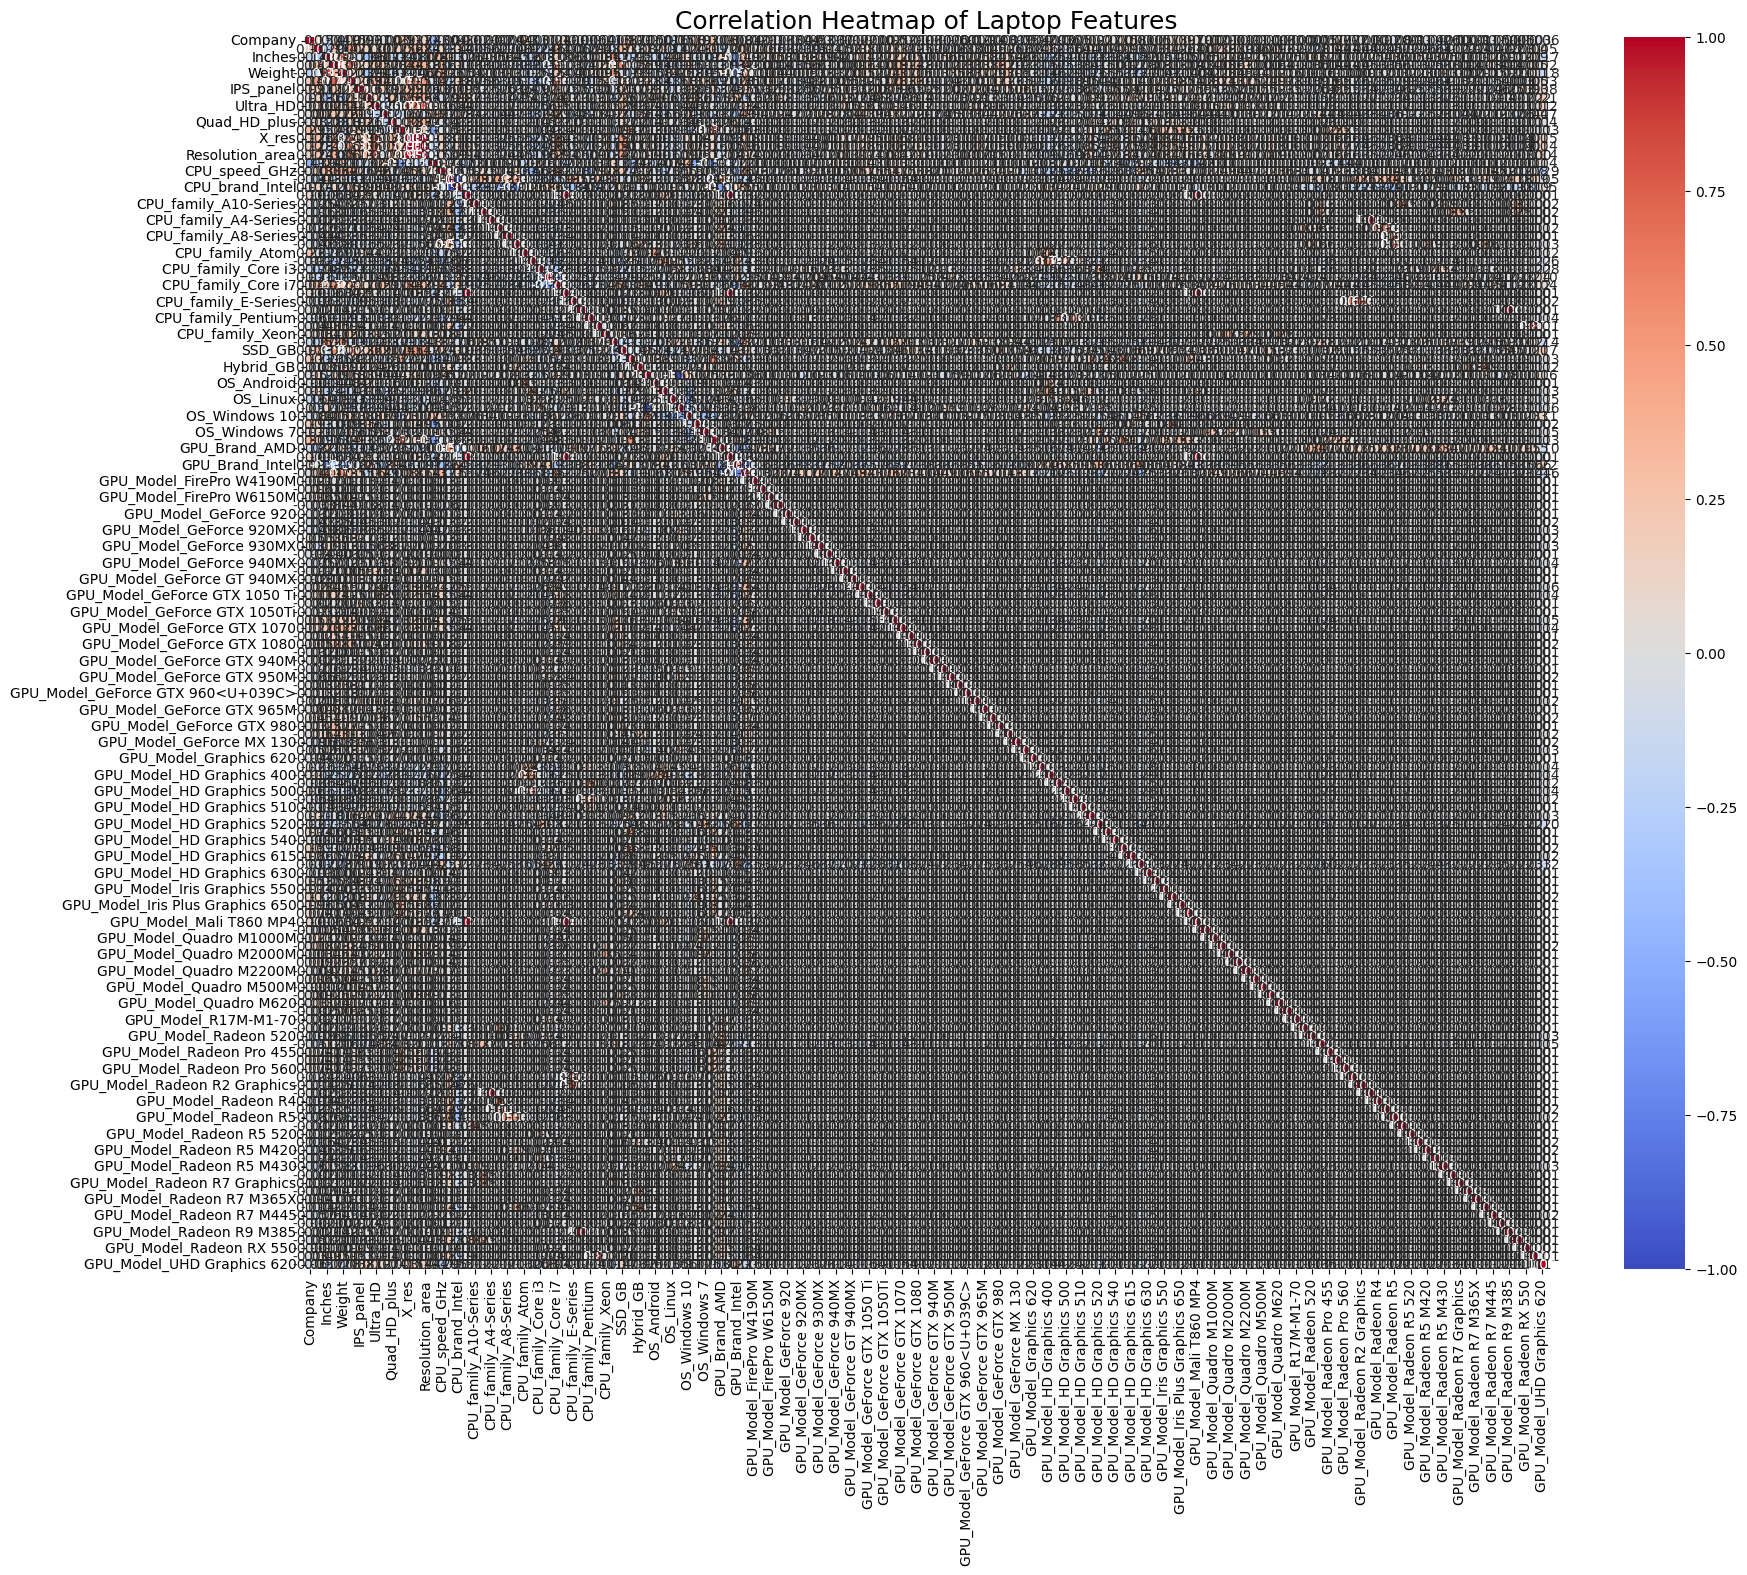

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt


corr = df_processed.corr()


plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Laptop Features", fontsize=18)
plt.show()


Intercept: 13774.58, Slope: 5519.90


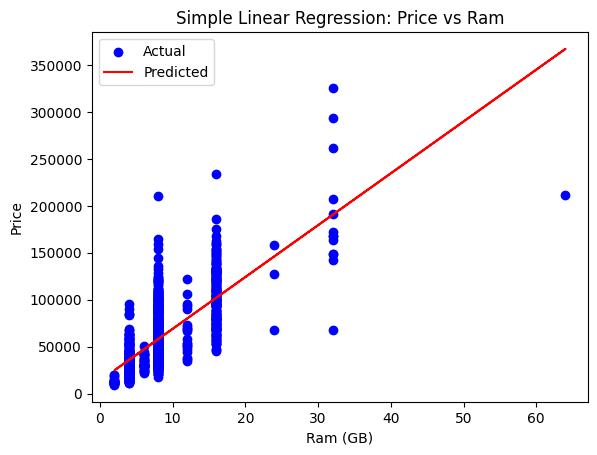

In [40]:
import numpy as np
import matplotlib.pyplot as plt

X = df_processed['Ram'].values  
y = df_processed['Price'].values  


X_b = np.c_[np.ones((len(X), 1)), X]  


theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept = theta[0]
slope = theta[1]
print(f"Intercept: {intercept:.2f}, Slope: {slope:.2f}")


y_pred = X_b.dot(theta)

plt.scatter(X, y, color='blue', label='Actual')
plt.plot(X, y_pred, color='red', label='Predicted')
plt.xlabel('Ram (GB)')
plt.ylabel('Price')
plt.title('Simple Linear Regression: Price vs Ram')
plt.legend()
plt.show()


In [41]:

import numpy as np


X = df_processed.drop('Price', axis=1).astype(float).values
y = df_processed['Price'].astype(float).values


X_b = np.c_[np.ones((len(X), 1)), X]


theta = np.linalg.pinv(X_b).dot(y)


for col, coef in zip(['Intercept'] + list(df_processed.drop('Price', axis=1).columns), theta):
    print(f"{col}: {coef:.2f}")



Intercept: 60116.52
Company: 876.83
TypeName: 2610.94
Inches: -645.29
Ram: 1503.07
Weight: -1416.89
IPS_panel: 620.26
Touchscreen: 4367.71
Ultra_HD: -19690.06
Full_HD: -14950.42
Quad_HD_plus: -34768.50
Retina_display: -22222.55
X_res: 145.85
Y_res: -152.38
Resolution_area: -0.01
Aspect_ratio: -107121.98
CPU_speed_GHz: 5289.41
CPU_brand_AMD: 22995.42
CPU_brand_Intel: 30891.20
CPU_brand_Samsung: 6229.90
CPU_family_A10-Series: 9357.56
CPU_family_A12-Series: 691.56
CPU_family_A4-Series: -3336.74
CPU_family_A6-Series: 5261.43
CPU_family_A8-Series: 8132.12
CPU_family_A9-Series: 2835.73
CPU_family_Atom: -14460.57
CPU_family_Celeron: 682.61
CPU_family_Core i3: 570.43
CPU_family_Core i5: 11763.69
CPU_family_Core i7: 15971.83
CPU_family_Cortex: 6229.90
CPU_family_E-Series: -799.78
CPU_family_FX: -7958.03
CPU_family_Pentium: 4716.07
CPU_family_Ryzen: 8811.56
CPU_family_Xeon: 62393.85
HDD_GB: 1.51
SSD_GB: 41.97
Flash_GB: 58.42
Hybrid_GB: 8.08
OS_present: 31527.83
OS_Android: 1554.62
OS_Chrome OS: 

In [42]:

print(df_processed.columns[df_processed.nunique() <= 1])


corr_matrix = df_processed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.999)]
print("Highly correlated / duplicate columns:", high_corr)


Index([], dtype='object')
Highly correlated / duplicate columns: ['CPU_family_Cortex', 'OS_No OS', 'GPU_Brand_ARM', 'GPU_Model_Mali T860 MP4', 'GPU_Model_Radeon R3', 'GPU_Model_Radeon R9 M385']


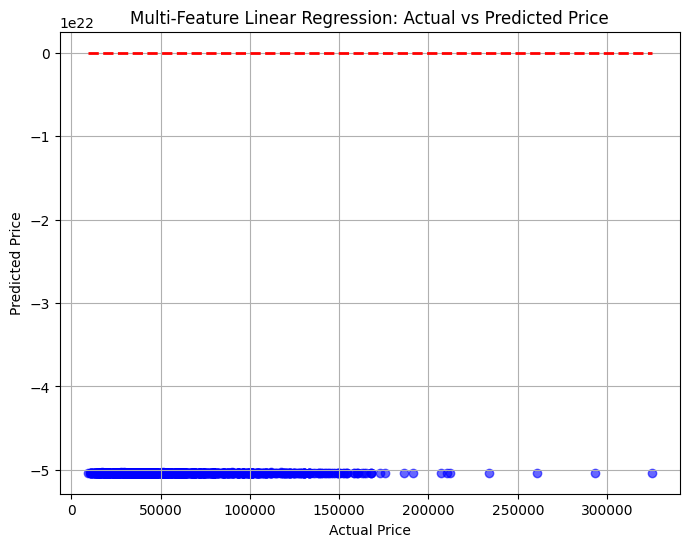

In [43]:
import matplotlib.pyplot as plt
import numpy as np


X = df_processed.drop('Price', axis=1).astype(float).values
y = df_processed['Price'].astype(float).values


X_mean = X.mean()
X_std = X.std()
X_scaled = (X - X_mean) / X_std


X_b = np.c_[np.ones((len(X_scaled), 1)), X_scaled]


theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)


y_pred = X_b.dot(theta)

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Multi-Feature Linear Regression: Actual vs Predicted Price')
plt.grid(True)
plt.show()



In [45]:
import numpy as np
import matplotlib.pyplot as plt


X = df_processed.drop('Price', axis=1).values.astype(float)
y = df_processed['Price'].values


X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

X_b = np.c_[np.ones((len(X_scaled), 1)), X_scaled]


theta_gd = np.zeros(X_b.shape[1])


learning_rate = 0.001
n_iterations = 50000
m = len(y)


loss_history = []
for i in range(n_iterations):
    y_pred = X_b.dot(theta_gd)
    error = y_pred - y
    loss = (error ** 2).mean()
    loss_history.append(loss)
    
    gradients = 2/m * X_b.T.dot(error)
    theta_gd -= learning_rate * gradients

print("First 5 predicted prices:", X_b.dot(theta_gd))



First 5 predicted prices: [53552.50770938 13517.16510035 11929.48378601 ... 37946.09814829
 87829.84848644 54092.89342581]


In [46]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, color='blue')
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.title("Gradient Descent Convergence")
plt.grid(True)
plt.show()


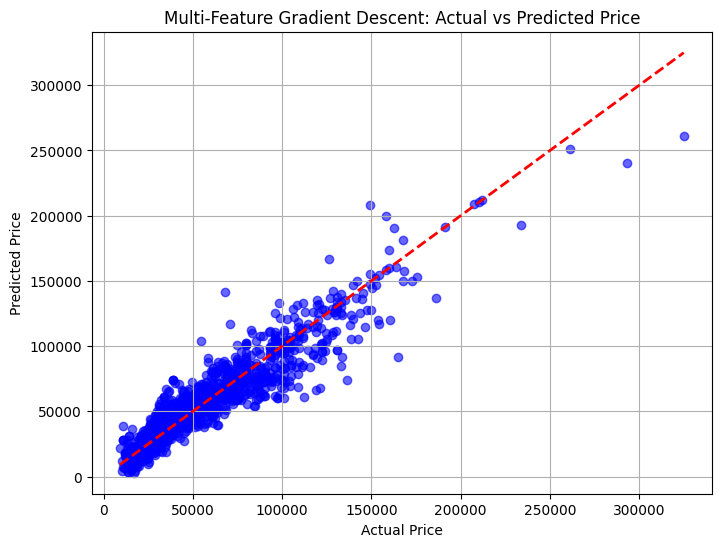

In [47]:
y_pred = X_b.dot(theta_gd)

plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Multi-Feature Gradient Descent: Actual vs Predicted Price")
plt.grid(True)
plt.show()


In [48]:

mse = np.mean((y - y_pred)**2)


rmse = np.sqrt(mse)


ss_total = np.sum((y - np.mean(y))**2)
ss_res = np.sum((y - y_pred)**2)
r2 = 1 - (ss_res / ss_total)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


MSE: 183214465.56
RMSE: 13535.67
R²: 0.8693


Regularization: lasso
MSE: 183214576.07, RMSE: 13535.68, R²: 0.8693
First 5 predicted prices: [ 53552.30217859  13516.61258269  11929.49618993 144570.82702445
  23296.09043449]


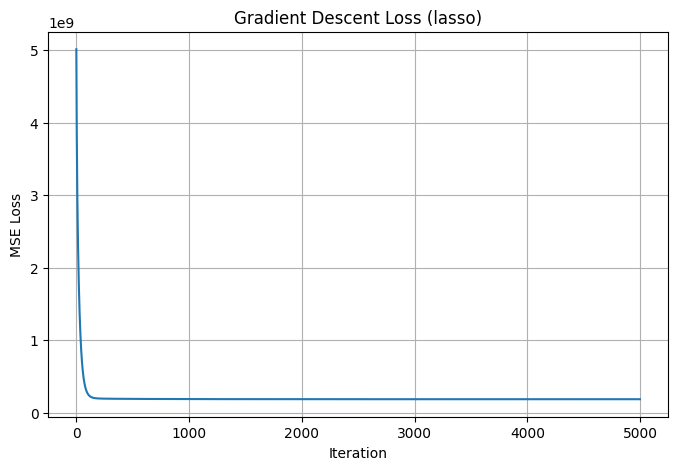

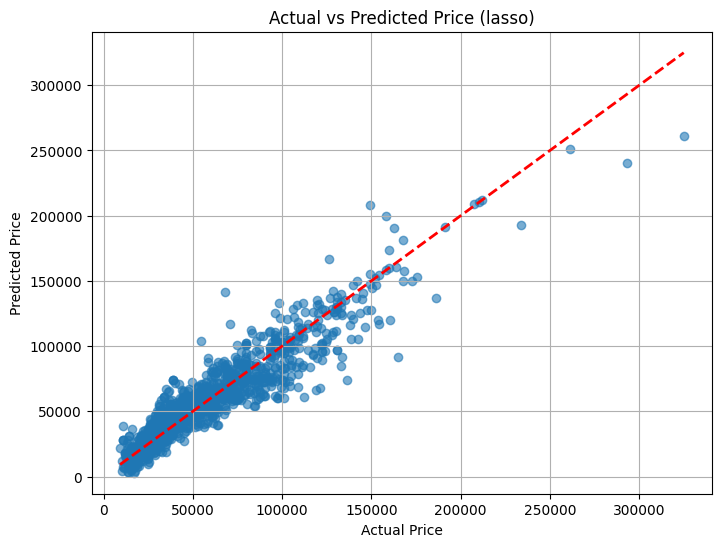

In [49]:
import numpy as np
import matplotlib.pyplot as plt


X = df_processed.drop('Price', axis=1).values.astype(float)
y = df_processed['Price'].values


X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std


X_b = np.c_[np.ones((len(X_scaled), 1)), X_scaled]


theta_gd = np.zeros(X_b.shape[1])


learning_rate = 0.01
n_iterations = 5000
m = len(y)


regularization = 'lasso'   
lambda_reg = 0.1           


loss_history = []
for i in range(n_iterations):
    y_pred = X_b.dot(theta_gd)
    error = y_pred - y
    loss = (error ** 2).mean()
    loss_history.append(loss)
    
    gradients = 2/m * X_b.T.dot(error)
    
    
    if regularization == 'ridge':
        gradients[1:] += 2 * lambda_reg * theta_gd[1:]
    elif regularization == 'lasso':
        gradients[1:] += lambda_reg * np.sign(theta_gd[1:])
    
    
    theta_gd -= learning_rate * gradients


y_pred_final = X_b.dot(theta_gd)

mse = np.mean((y - y_pred_final) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y - y_pred_final) ** 2)/np.sum((y - np.mean(y))**2)

print(f"Regularization: {regularization}")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
print("First 5 predicted prices:", y_pred_final[:5])


plt.figure(figsize=(8,5))
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title(f'Gradient Descent Loss ({regularization})')
plt.grid(True)
plt.show()


plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_final, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Price ({regularization})')
plt.grid(True)
plt.show()


Lambda=0.000 -> RMSE=13535.67
Lambda=0.010 -> RMSE=13553.63
Lambda=0.050 -> RMSE=13676.90
Lambda=0.100 -> RMSE=13818.48
Lambda=0.500 -> RMSE=14944.08
Lambda=1.000 -> RMSE=16390.04
Lambda=5.000 -> RMSE=23659.21
Lambda=10.000 -> RMSE=27783.75

Best lambda: 0.0, Best RMSE: 13535.67
R²: 0.8693


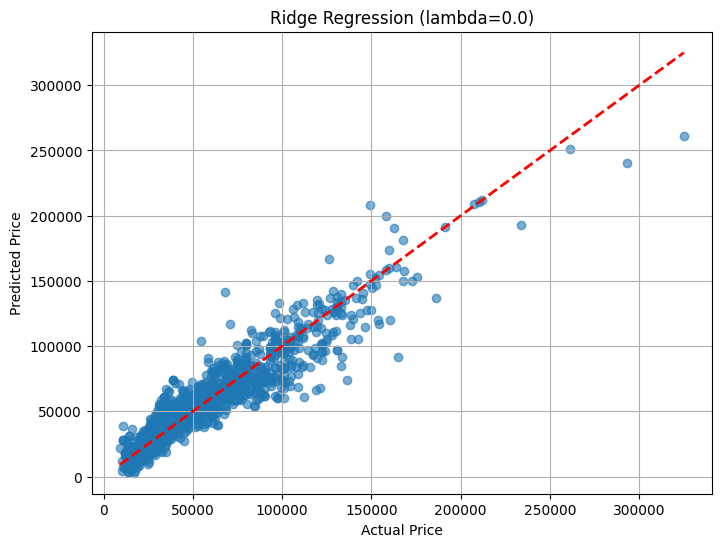

In [50]:
import numpy as np
import matplotlib.pyplot as plt

X = df_processed.drop('Price', axis=1).values.astype(float)
y = df_processed['Price'].values.reshape(-1,1)


X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std


X_b = np.c_[np.ones((len(X_scaled), 1)), X_scaled]


learning_rate = 0.01
n_iterations = 5000
m = len(y)

lambda_values = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
best_rmse = np.inf
best_lambda = None
best_theta = None

for lambda_ridge in lambda_values:
    theta = np.zeros((X_b.shape[1],1))
    for i in range(n_iterations):
        y_pred = X_b.dot(theta)
        error = y_pred - y
        gradients = 2/m * X_b.T.dot(error)
        
        gradients[1:] += 2 * lambda_ridge * theta[1:]
        theta -= learning_rate * gradients
    
    
    y_pred_final = X_b.dot(theta)
    mse = np.mean((y - y_pred_final)**2)
    rmse = np.sqrt(mse)
    
    print(f"Lambda={lambda_ridge:.3f} -> RMSE={rmse:.2f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_lambda = lambda_ridge
        best_theta = theta.copy()

print(f"\nBest lambda: {best_lambda}, Best RMSE: {best_rmse:.2f}")


y_pred_best = X_b.dot(best_theta)


r2 = 1 - np.sum((y - y_pred_best)**2)/np.sum((y - np.mean(y))**2)
print(f"R²: {r2:.4f}")


plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_best, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Ridge Regression (lambda={best_lambda})')
plt.grid(True)
plt.show()


Polynomial Linear Regression -> MSE: 174922403.00, RMSE: 13225.82, R²: 0.8752


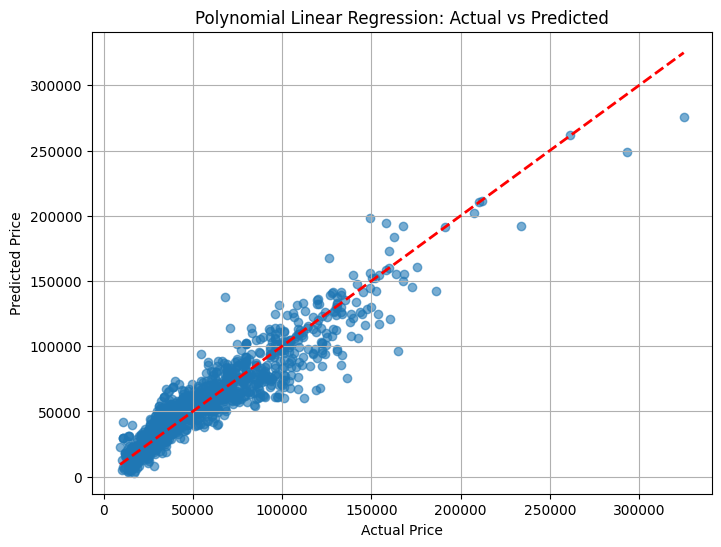

In [51]:
import numpy as np
import matplotlib.pyplot as plt


numeric_features = ['Ram', 'CPU_speed_GHz', 'SSD_GB', 'X_res', 'Y_res']
X_numeric = df_processed[numeric_features].astype(float).values


X_poly = X_numeric.copy()
for i in range(X_numeric.shape[1]):
    X_poly = np.c_[X_poly, X_numeric[:, i]**4, X_numeric[:, i]**5]


for i in range(X_numeric.shape[1]):
    for j in range(i+1, X_numeric.shape[1]):
        X_poly = np.c_[X_poly, X_numeric[:, i]*X_numeric[:, j]]


X_others = df_processed.drop(numeric_features + ['Price'], axis=1).astype(float).values
X_all = np.c_[X_poly, X_others]


X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0)
X_scaled = (X_all - X_mean) / X_std

X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]
y = df_processed['Price'].values

theta = np.zeros(X_b.shape[1])
learning_rate = 0.001
n_iterations = 50000
m = len(y)


for i in range(n_iterations):
    y_pred = X_b.dot(theta)
    error = y_pred - y
    gradients = 2/m * X_b.T.dot(error)
    theta -= learning_rate * gradients

y_pred_final = X_b.dot(theta)


mse = np.mean((y - y_pred_final)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y - y_pred_final)**2)/np.sum((y - np.mean(y))**2)

print(f"Polynomial Linear Regression -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


plt.figure(figsize=(8,6))
plt.scatter(y, y_pred_final, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Polynomial Linear Regression: Actual vs Predicted')
plt.grid(True)
plt.show()


Polynomial Linear Regression (log target) -> MSE: 178118949.52, RMSE: 13346.12, R²: 0.8730


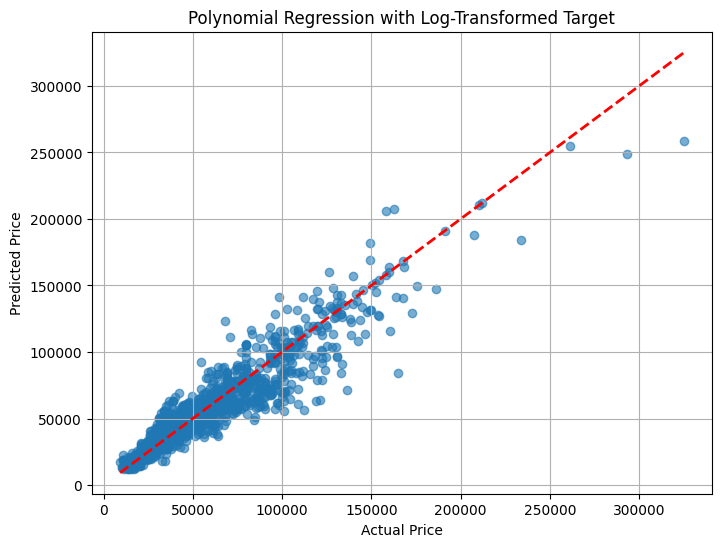

In [52]:
import numpy as np
import matplotlib.pyplot as plt


numeric_features = ['Ram', 'CPU_speed_GHz', 'SSD_GB', 'Y_res']
X_numeric = df_processed[numeric_features].astype(float).values

X_poly = X_numeric.copy()
for i in range(X_numeric.shape[1]):
    X_poly = np.c_[X_poly, X_numeric[:, i]**2, X_numeric[:, i]**3]

for i in range(X_numeric.shape[1]):
    for j in range(i+1, X_numeric.shape[1]):
        X_poly = np.c_[X_poly, X_numeric[:, i]*X_numeric[:, j]]


X_others = df_processed.drop(numeric_features + ['Price'], axis=1).astype(float).values
X_all = np.c_[X_poly, X_others]


X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0)
X_scaled = (X_all - X_mean) / X_std

X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]

y_log = np.log1p(df_processed['Price'].values)  


theta = np.zeros(X_b.shape[1])
learning_rate = 0.001
n_iterations = 50000
m = len(y_log)

for i in range(n_iterations):
    y_pred_log = X_b.dot(theta)
    error = y_pred_log - y_log
    gradients = 2/m * X_b.T.dot(error)
    theta -= learning_rate * gradients

y_pred_final = np.expm1(X_b.dot(theta))  


mse = np.mean((df_processed['Price'].values - y_pred_final)**2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((df_processed['Price'].values - y_pred_final)**2) / np.sum((df_processed['Price'].values - np.mean(df_processed['Price'].values))**2)

print(f"Polynomial Linear Regression (log target) -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(df_processed['Price'], y_pred_final, alpha=0.6)
plt.plot([df_processed['Price'].min(), df_processed['Price'].max()],
         [df_processed['Price'].min(), df_processed['Price'].max()],
         'r--', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Polynomial Regression with Log-Transformed Target')
plt.grid(True)
plt.show()


In [53]:
def segment_laptops_onehot(df):
    """
    Segments laptops into High, Mid, Low using one-hot encoded CPU and GPU columns.
    """
    
    cpu_cols = ['CPU_family_i7','CPU_family_i9','CPU_family_Ryzen7','CPU_family_Ryzen9',
                'CPU_family_i5','CPU_family_Ryzen5']
    gpu_cols = ['GPU_Brand_Nvidia','GPU_Brand_AMD']

    for col in cpu_cols + gpu_cols:
        if col not in df.columns:
            df[col] = 0

    
    high_end_mask = (
        (df['CPU_family_i7'] == 1) |
        (df['CPU_family_i9'] == 1) |
        (df['CPU_family_Ryzen7'] == 1) |
        (df['CPU_family_Ryzen9'] == 1) |
        (((df['GPU_Brand_Nvidia'] == 1) | (df['GPU_Brand_AMD'] == 1)) & (df['Ram'] >= 16))
    )

    mid_end_mask = (
        (df['CPU_family_i5'] == 1) |
        (df['CPU_family_Ryzen5'] == 1) |
        (((df['GPU_Brand_Nvidia'] == 1) | (df['GPU_Brand_AMD'] == 1)) & (df['Ram'] >= 8))
    ) & (~high_end_mask)

   
    df['Segment'] = 'Low'
    df.loc[mid_end_mask, 'Segment'] = 'Mid'
    df.loc[high_end_mask, 'Segment'] = 'High'

    return df

df_segmented = segment_laptops_onehot(df_processed)
df_segmented['Segment'].value_counts()


Segment
Low     752
Mid     266
High    154
Name: count, dtype: int64

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_gd(df, target='Price', learning_rate=0.001, n_iterations=50000):
    """
    Fits a linear regression using gradient descent for each laptop segment.
    Returns a dictionary with segment-wise models and predictions.
    """
    results = {}
    segments = df['Segment'].unique()
    
    for seg in segments:
        df_seg = df[df['Segment'] == seg].copy()
        
        
        X = df_seg.drop([target, 'Segment'], axis=1).astype(float).values
        y = df_seg[target].astype(float).values
        
        
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X_std_safe = np.where(X_std == 0, 1, X_std)  
        X_scaled = (X - X_mean) / X_std_safe

        
     
        X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]
        
        
        theta = np.zeros(X_b.shape[1])
        m = len(y)
        
        
        for i in range(n_iterations):
            y_pred = X_b.dot(theta)
            error = y_pred - y
            gradients = 2/m * X_b.T.dot(error)
            theta -= learning_rate * gradients
        
       
        y_pred_final = X_b.dot(theta)
        mse = np.mean((y - y_pred_final)**2)
        rmse = np.sqrt(mse)
        r2 = 1 - np.sum((y - y_pred_final)**2)/np.sum((y - np.mean(y))**2)
        
        results[seg] = {
            'theta': theta,
            'X_b': X_b,
            'y_true': y,
            'y_pred': y_pred_final,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
        print(f"Segment: {seg} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    
    return results


segment_models = linear_regression_gd(df_segmented)


plt.figure(figsize=(12,6))
colors = {'Low':'blue', 'Mid':'orange', 'High':'green'}

for seg, data in segment_models.items():
    plt.scatter(data['y_true'], data['y_pred'], color=colors.get(seg,'gray'),
                alpha=0.6, label=f"{seg} segment")

plt.plot([df_segmented['Price'].min(), df_segmented['Price'].max()],
         [df_segmented['Price'].min(), df_segmented['Price'].max()],
         color='red', linestyle='--', linewidth=2, label='Perfect fit')

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Segment-wise Linear Regression: Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()


Segment: Mid -> MSE: 64891052.88, RMSE: 8055.50, R²: 0.8897
Segment: Low -> MSE: 158072470.88, RMSE: 12572.69, R²: 0.8287
Segment: High -> MSE: 281043041.05, RMSE: 16764.34, R²: 0.8628


In [55]:
import matplotlib.pyplot as plt
import numpy as np

segments = df_segmented['Segment'].unique()
segment_thetas = {}  

for seg in segments:
    seg_df = df_segmented[df_segmented['Segment'] == seg]
    X = seg_df.drop(['Price','Segment'], axis=1).astype(float).values
    y = seg_df['Price'].values
    
    
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std_safe = np.where(X_std == 0, 1, X_std)  
    X_scaled = (X - X_mean) / X_std_safe
    X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]
    
    
    theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    segment_thetas[seg] = theta  
    y_pred = X_b.dot(theta)
    
    
    mse = np.mean((y - y_pred)**2)
    rmse = np.sqrt(mse)
    r2 = 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2)
    print(f"Segment: {seg} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


plt.figure(figsize=(15,5))
for i, seg in enumerate(segments, 1):
    plt.subplot(1, 3, i)
    seg_df = df_segmented[df_segmented['Segment'] == seg]
    X = seg_df.drop(['Price','Segment'], axis=1).astype(float).values
    y = seg_df['Price'].values
    
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std_safe = np.where(X_std == 0, 1, X_std)
    X_scaled = (X - X_mean) / X_std_safe
    X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]
    
    y_pred = X_b.dot(segment_thetas[seg])
    
    plt.scatter(y, y_pred, alpha=0.6, color='blue')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{seg} Segment')
    plt.grid(True)

plt.tight_layout()
plt.show()


Segment: Mid -> MSE: 64038987.72, RMSE: 8002.44, R²: 0.8912
Segment: Low -> MSE: 157670130.80, RMSE: 12556.68, R²: 0.8291
Segment: High -> MSE: 281042953.12, RMSE: 16764.34, R²: 0.8628


In [56]:
def safe_bool_col(df, col):
    """Return a boolean Series if col exists, else a Series of False."""
    if col in df.columns:
        return df[col].astype(bool)
    else:
        return pd.Series([False] * len(df), index=df.index)

def segment_laptops_labelencoded(df):
    """
    Segment laptops into Low, Mid, High-end based on key features.
    Works when TypeName is integer-encoded and CPU/GPU/OS are one-hot.
    """
    df = df.copy()
    df['Segment'] = 'Mid'  
    gaming_type_value = 2   
    ultrabook_type_value = 3  
    notebook_type_value = 0 

    
    high_end_mask = (
        (df['TypeName'] == gaming_type_value) &
        (df['Inches'] >= 17) & (df['Ram'] > 16) &
        safe_bool_col(df, 'GPU_Brand_Nvidia') &
        safe_bool_col(df, 'OS_Windows 10')
    )
    df.loc[high_end_mask, 'Segment'] = 'High'

    
    low_end_mask = (
        safe_bool_col(df, 'CPU_family_Core i3') | 
        (df['Ram'] < 8) |
        (df['TypeName'] == notebook_type_value) 
    )
    low_end_mask &= ~high_end_mask
    df.loc[low_end_mask, 'Segment'] = 'Low'

    return df

df_segmented = segment_laptops_labelencoded(df_processed)
print(df_segmented['Segment'].value_counts())


Segment
Low     721
Mid     437
High     14
Name: count, dtype: int64


In [57]:

typename_mapping = pd.factorize(df['TypeName'])[1]
print("TypeName mapping:")
for code, label in enumerate(typename_mapping):
    print(f"{code} -> {label}")


TypeName mapping:
0 -> Notebook
1 -> 2 in 1 Convertible
2 -> Gaming
3 -> Ultrabook
4 -> Workstation
5 -> Netbook


In [58]:
import numpy as np
import matplotlib.pyplot as plt

def linear_regression_gd(df, target='Price', learning_rate=0.001, n_iterations=50000):
    """
    Fits a linear regression using gradient descent for each laptop segment.
    Returns a dictionary with segment-wise models and predictions.
    """
    results = {}
    segments = df['Segment'].unique()
    
    for seg in segments:
        df_seg = df[df['Segment'] == seg].copy()
        
        
        X = df_seg.drop([target, 'Segment'], axis=1).astype(float).values
        y = df_seg[target].astype(float).values
        
        
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X_std_safe = np.where(X_std == 0, 1, X_std)  
        X_scaled = (X - X_mean) / X_std_safe

        
        
        X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]
        
        
        theta = np.zeros(X_b.shape[1])
        m = len(y)
        
        
        for i in range(n_iterations):
            y_pred = X_b.dot(theta)
            error = y_pred - y
            gradients = 2/m * X_b.T.dot(error)
            theta -= learning_rate * gradients
        
        
        y_pred_final = X_b.dot(theta)
        mse = np.mean((y - y_pred_final)**2)
        rmse = np.sqrt(mse)
        r2 = 1 - np.sum((y - y_pred_final)**2)/np.sum((y - np.mean(y))**2)
        
        results[seg] = {
            'theta': theta,
            'X_b': X_b,
            'y_true': y,
            'y_pred': y_pred_final,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
        print(f"Segment: {seg} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    
    return results


segment_models = linear_regression_gd(df_segmented)


plt.figure(figsize=(12,6))
colors = {'Low':'blue', 'Mid':'orange', 'High':'green'}

for seg, data in segment_models.items():
    plt.scatter(data['y_true'], data['y_pred'], color=colors.get(seg,'gray'),
                alpha=0.6, label=f"{seg} segment")

plt.plot([df_segmented['Price'].min(), df_segmented['Price'].max()],
         [df_segmented['Price'].min(), df_segmented['Price'].max()],
         color='red', linestyle='--', linewidth=2, label='Perfect fit')

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Segment-wise Linear Regression: Actual vs Predicted Price')
plt.legend()
plt.grid(True)
plt.show()


Segment: Low -> MSE: 89077773.81, RMSE: 9438.10, R²: 0.8408
Segment: Mid -> MSE: 239534907.76, RMSE: 15476.92, R²: 0.7547
Segment: High -> MSE: 12254347.47, RMSE: 3500.62, R²: 0.9973


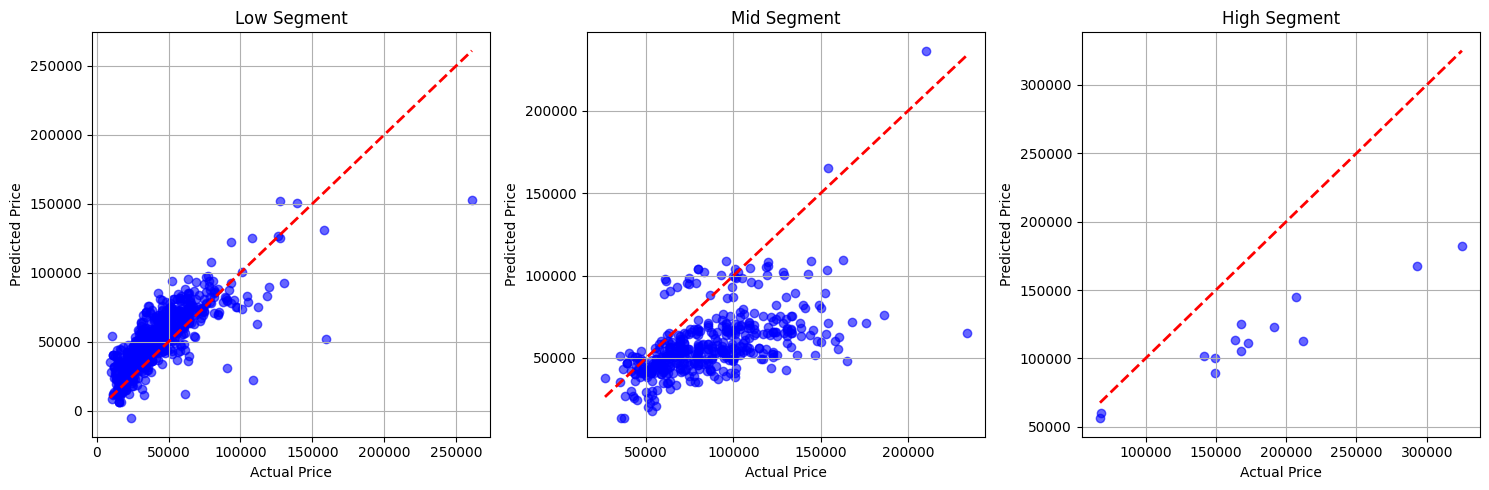

In [59]:
import matplotlib.pyplot as plt

segments = df_segmented['Segment'].unique()
plt.figure(figsize=(15,5))

for i, seg in enumerate(segments, 1):
    plt.subplot(1, 3, i)
    seg_df = df_segmented[df_segmented['Segment'] == seg]
    X = seg_df.drop(['Price','Segment'], axis=1).astype(float).values
    y = seg_df['Price'].values
    
   
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std_safe = np.where(X_std == 0, 1, X_std)
    X_scaled = (X - X_mean) / X_std_safe
    X_b = np.c_[np.ones((len(X_scaled),1)), X_scaled]
    
    
    theta = segment_thetas[seg]  
    y_pred = X_b.dot(theta)
    
    plt.scatter(y, y_pred, alpha=0.6, color='blue')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{seg} Segment')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [60]:

all_y_true = np.concatenate([data['y_true'] for data in segment_models.values()])
all_y_pred = np.concatenate([data['y_pred'] for data in segment_models.values()])


mse_global = np.mean((all_y_true - all_y_pred)**2)
rmse_global = np.sqrt(mse_global)
r2_global = 1 - np.sum((all_y_true - all_y_pred)**2) / np.sum((all_y_true - np.mean(all_y_true))**2)

print(f"Global -> MSE: {mse_global:.2f}, RMSE: {rmse_global:.2f}, R²: {r2_global:.4f}")


Global -> MSE: 144260572.08, RMSE: 12010.85, R²: 0.8971


In [61]:
#data exploration again

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(r"C:\Users\tanvi\Documents\Tanvi_Jain_A1\laptop_price_task\data\Laptop Price.csv")

print(data.shape)
print(data.isnull().sum())
print(data.head())

(1172, 11)
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64
  Company            TypeName  Inches       ScreenResolution  \
0    Acer            Notebook    15.6      Full HD 1920x1080   
1    Asus            Notebook    14.0               1366x768   
2    Dell            Notebook    15.6               1366x768   
3  Lenovo  2 in 1 Convertible    14.0  Touchscreen 2560x1440   
4    Acer            Notebook    15.6               1366x768   

                                    Cpu   Ram              Memory  \
0           Intel Core i7 7700HQ 2.8GHz   8GB           256GB SSD   
1  Intel Celeron Dual Core N3350 1.1GHz   4GB  32GB Flash Storage   
2  Intel Celeron Dual Core N3060 1.6GHz   4GB           500GB HDD   
3            Intel Core i7 7500U 2.7GHz  16GB             1TB SSD   
4   

In [62]:
#remove characters from numerical data
data['Ram'] = data['Ram'].str.replace("GB", "")
data['Weight'] = data['Weight'].str.replace("kg", "")
data['Ram'] = data['Ram'].astype('int32')
data['Weight'] = data['Weight'].astype('float32')

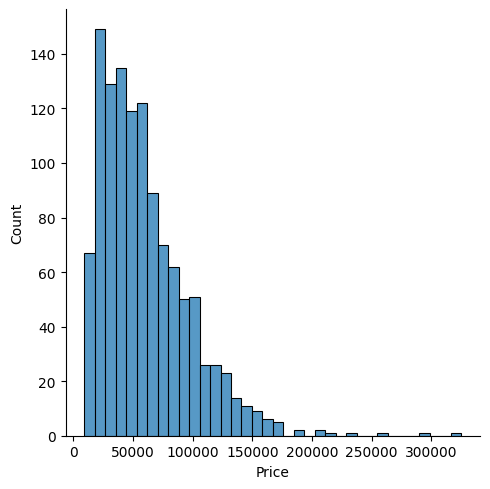

In [63]:
#distribution of price 
sns.displot(data['Price'])
plt.show()

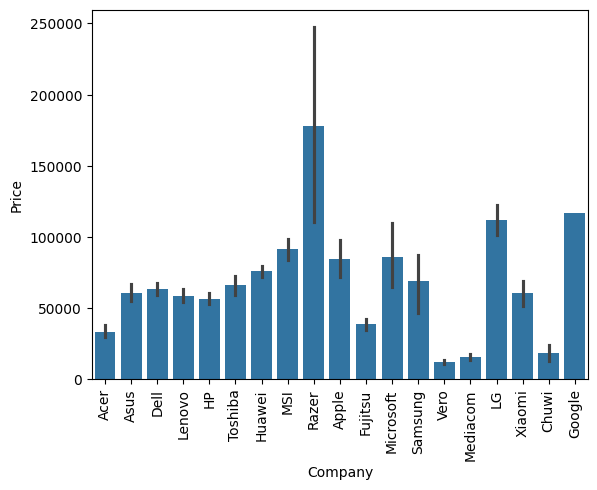

In [64]:
#average price of each brand

sns.barplot(x=data['Company'], y=data['Price'])

plt.xticks(rotation="vertical")

plt.show()

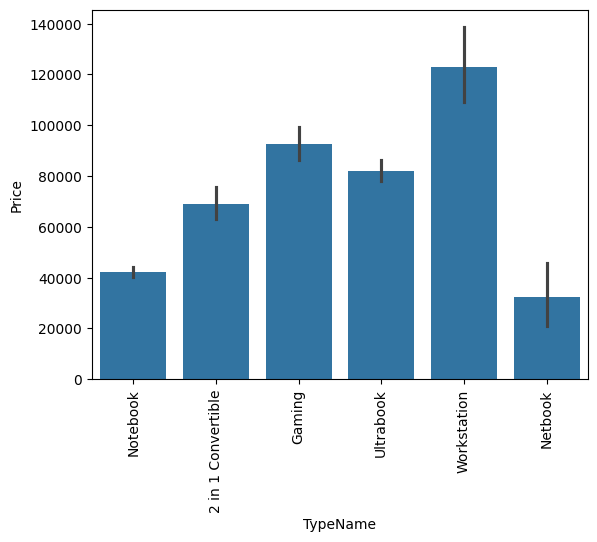

In [65]:

sns.barplot(x=data['TypeName'], y=data['Price'])
plt.xticks(rotation="vertical")
plt.show()

<Axes: xlabel='Inches', ylabel='Price'>

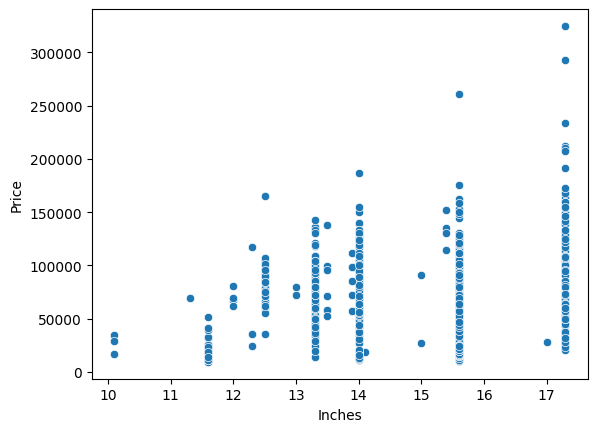

In [66]:
sns.scatterplot(x=data['Inches'],y=data['Price'])

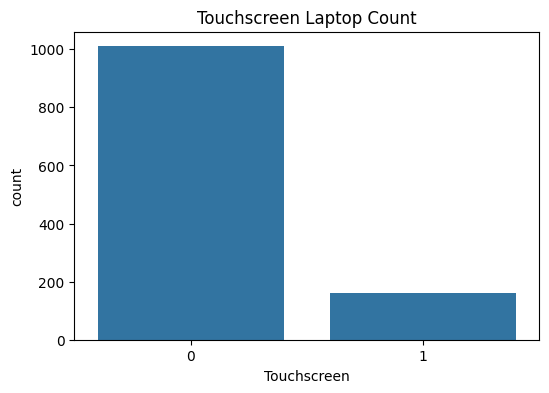

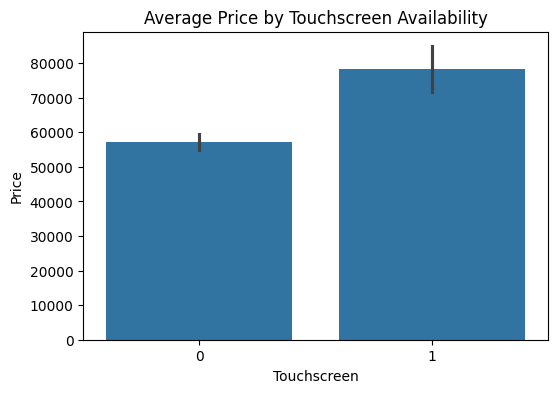

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

data['Touchscreen'] = data['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in str(x) else 0)


plt.figure(figsize=(6,4))
sns.countplot(x='Touchscreen', data=data)
plt.title("Touchscreen Laptop Count")
plt.show()


plt.figure(figsize=(6,4))
sns.barplot(x='Touchscreen', y='Price', data=data, estimator=np.mean)
plt.title("Average Price by Touchscreen Availability")
plt.show()

<Axes: xlabel='Ips', ylabel='Price'>

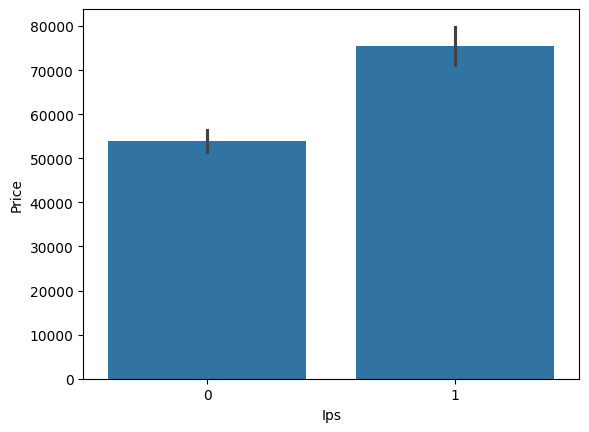

In [68]:

data['Ips'] = data['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)
sns.barplot(x=data['Ips'],y=data['Price'])

In [69]:
import pandas as pd

data[['X_res','Y_res']] = data['ScreenResolution'].str.extract(r'(\d+)[xX](\d+)')


data['X_res'] = data['X_res'].astype(int)
data['Y_res'] = data['Y_res'].astype(int)

# PPI = diagonal resolution / screen size 
data['ppi'] = (((data['X_res']**2 + data['Y_res']**2) ** 0.5) / data['Inches']).astype(float)

correlations = data.corr(numeric_only=True)['Price'].sort_values(ascending=False)
print(correlations)


Price          1.000000
Ram            0.742514
X_res          0.554475
Y_res          0.551422
ppi            0.470543
Ips            0.259750
Weight         0.216858
Touchscreen    0.194396
Inches         0.072210
Name: Price, dtype: float64


In [70]:
data.drop(columns = ['ScreenResolution', 'Inches','X_res','Y_res'], inplace=True)

In [71]:
#extract CPU name and processor
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  else:
    return 'AMD Processor'
data['Cpu_brand'] = data['Cpu'].apply(lambda x: fetch_processor(x))

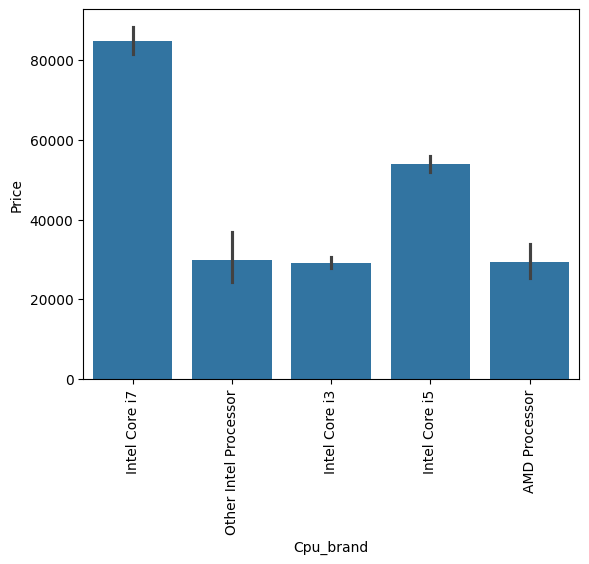

In [72]:
sns.barplot(x=data['Cpu_brand'],y=data['Price'])
plt.xticks(rotation='vertical')
plt.show()

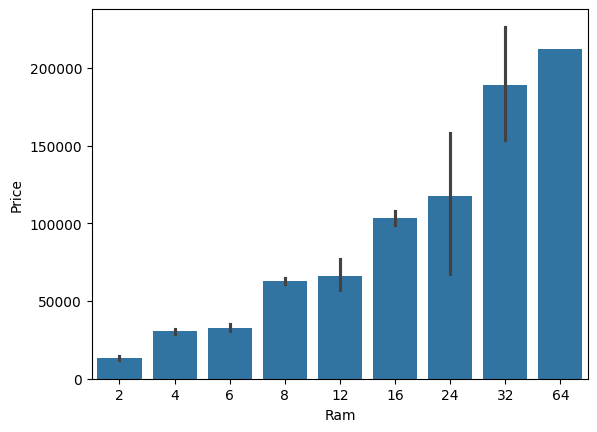

In [73]:
sns.barplot(x=data['Ram'], y=data['Price'])
plt.show()

In [74]:
import re
import pandas as pd

def parse_memory(df, col="Memory"):
    """
    Splits the Memory column into numeric GB values for:
    - HDD_GB
    - SSD_GB
    - Flash_GB
    - Hybrid_GB
    """

    
    df["HDD_GB"] = 0
    df["SSD_GB"] = 0
    df["Flash_GB"] = 0
    df["Hybrid_GB"] = 0

    def size_to_gb(size_str):
        """Convert '1TB' -> 1000, '256GB' -> 256"""
        if "TB" in size_str:
            return float(size_str.replace("TB", "").strip()) * 1000
        elif "GB" in size_str:
            return float(size_str.replace("GB", "").strip())
        return 0

    for i, entry in df[col].items():
        if pd.isna(entry):
            continue

        parts = [p.strip() for p in entry.split("+")]

        for p in parts:
            
            size_match = re.search(r"(\d+\.?\d*)(TB|GB)", p)
            if not size_match:
                continue

            size_gb = size_to_gb(size_match.group(0))

            if "HDD" in p:
                df.at[i, "HDD_GB"] += size_gb
            elif "SSD" in p:
                df.at[i, "SSD_GB"] += size_gb
            elif "Flash" in p:
                df.at[i, "Flash_GB"] += size_gb
            elif "Hybrid" in p:
                df.at[i, "Hybrid_GB"] += size_gb

 
    df = df.drop(columns=[col])
    return df


In [75]:
# Correlation of all features with Price
correlations = data.corr(numeric_only=True)['Price'].sort_values(ascending=False)
print(correlations)

Price          1.000000
Ram            0.742514
ppi            0.470543
Ips            0.259750
Weight         0.216858
Touchscreen    0.194396
Name: Price, dtype: float64


In [76]:
#data.drop(columns=['Layer1Hybrid','Layer2Hybrid', 'Layer1Flash_Storage','Layer2Flash_Storage', 'Memory','Cpu'],inplace=True)

In [77]:

data['Gpu_brand'] = data['Gpu'].apply(lambda x: x.split()[0])

data = data[data['Gpu_brand'] != 'ARM']

data = data.drop(columns=['Gpu'])


In [78]:

def cat_os(inp):
    if inp in ['Windows 10', 'Windows 7', 'Windows 10 S']:
        return 'Windows'
    elif inp in ['macOS', 'Mac OS X']:
        return 'Mac'
    else:
        return 'Others/No OS/Linux'

data['os'] = data['OpSys'].apply(cat_os)


data = data.drop(columns=['OpSys'])


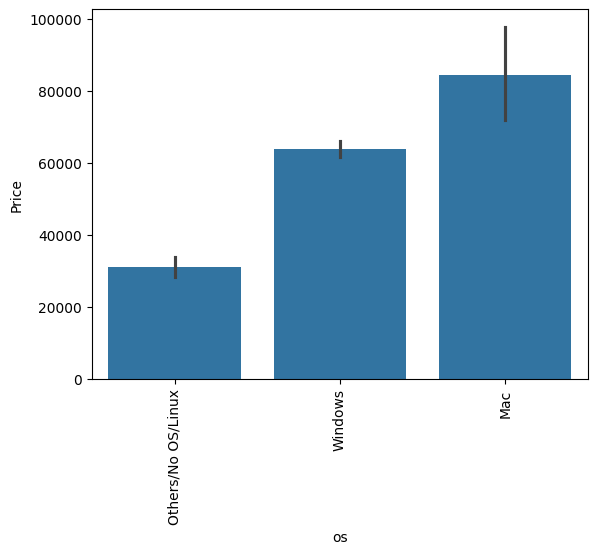

In [79]:
sns.barplot(x=data['os'],y=data['Price'])
plt.xticks(rotation='vertical')
plt.show()

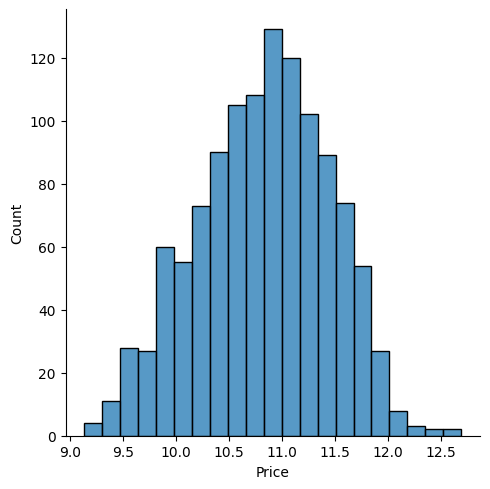

In [80]:
sns.displot(np.log(data['Price']))
plt.show()

In [81]:
print(data.head())
print("\nData types:\n", data.dtypes)

  Company            TypeName                                   Cpu  Ram  \
0    Acer            Notebook           Intel Core i7 7700HQ 2.8GHz    8   
1    Asus            Notebook  Intel Celeron Dual Core N3350 1.1GHz    4   
2    Dell            Notebook  Intel Celeron Dual Core N3060 1.6GHz    4   
3  Lenovo  2 in 1 Convertible            Intel Core i7 7500U 2.7GHz   16   
4    Acer            Notebook              Intel Core i3 6006U 2GHz    4   

               Memory  Weight       Price  Touchscreen  Ips         ppi  \
0           256GB SSD    2.50   52161.120            0    0  141.211998   
1  32GB Flash Storage    1.50   14811.840            0    0  111.935204   
2           500GB HDD    2.20   14646.672            0    0  100.454670   
3             1TB SSD    1.42  150462.720            1    0  209.800683   
4           500GB HDD    2.40   23976.000            0    0  100.454670   

               Cpu_brand Gpu_brand                  os  
0          Intel Core i7    Nvidia 

In [82]:
import numpy as np
import pandas as pd


class DecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.tree = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else self.n_features
        self.tree = self._grow_tree(X, y)

    def _mse(self, y):
        return np.var(y) * len(y)

    def _best_split(self, X, y, feat_idx):
        best_mse, split_idx, split_thr = float("inf"), None, None
        thresholds = np.unique(X[:, feat_idx])
        for t in thresholds:
            left_mask = X[:, feat_idx] <= t
            right_mask = ~left_mask
            if left_mask.sum() == 0 or right_mask.sum() == 0:
                continue
            mse = self._mse(y[left_mask]) + self._mse(y[right_mask])
            if mse < best_mse:
                best_mse, split_idx, split_thr = mse, feat_idx, t
        return split_idx, split_thr, best_mse

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        if (depth >= self.max_depth) or (n_samples < self.min_samples_split):
            return {"value": y.mean()}

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best = {"mse": float("inf")}
        for feat_idx in feat_idxs:
            split_idx, split_thr, mse = self._best_split(X, y, feat_idx)
            if split_idx is not None and mse < best["mse"]:
                best = {"mse": mse, "feature": split_idx, "threshold": split_thr}

        if best["mse"] == float("inf"):
            return {"value": y.mean()}

        left_mask = X[:, best["feature"]] <= best["threshold"]
        right_mask = ~left_mask
        left_child = self._grow_tree(X[left_mask], y[left_mask], depth+1)
        right_child = self._grow_tree(X[right_mask], y[right_mask], depth+1)
        return {"feature": best["feature"], "threshold": best["threshold"], "left": left_child, "right": right_child}

    def _predict_sample(self, inputs, tree):
        if "value" in tree:
            return tree["value"]
        if inputs[tree["feature"]] <= tree["threshold"]:
            return self._predict_sample(inputs, tree["left"])
        else:
            return self._predict_sample(inputs, tree["right"])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])


class RandomForest:
    def __init__(self, n_estimators=50, max_depth=10, min_samples_split=2, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                n_features=self.max_features or int(np.sqrt(X.shape[1]))
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(preds, axis=0)



def train_test_split(X, y, test_size=0.15, random_state=2):
    np.random.seed(random_state)
    n_samples = len(X)
    test_size = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_idx, train_idx = indices[:test_size], indices[test_size:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


X = data.drop(columns=['Price']).values
y = np.log(data['Price'].values)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

rf = RandomForest(n_estimators=30, max_depth=12, min_samples_split=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f"Random Forest -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Random Forest -> MSE: 0.04, RMSE: 0.20, R²: 0.9013


Random Forest -> MSE: 0.04, RMSE: 0.20, R²: 0.9013


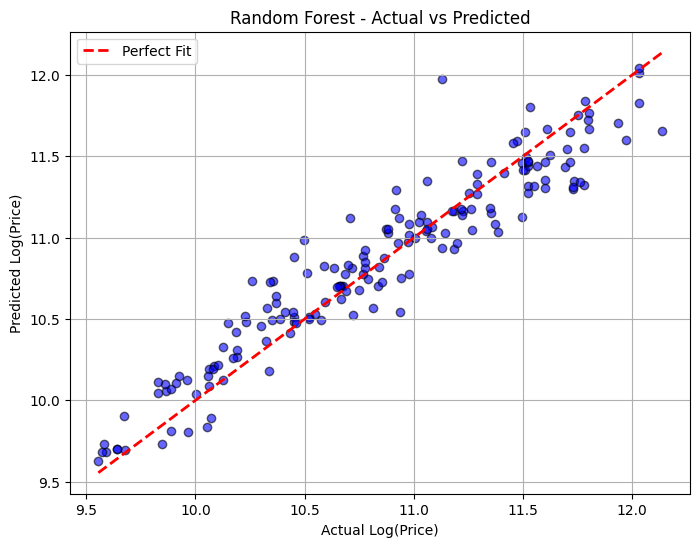

In [83]:
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)


mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f"Random Forest -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", edgecolor="k")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2, label="Perfect Fit")
plt.xlabel("Actual Log(Price)")
plt.ylabel("Predicted Log(Price)")
plt.title("Random Forest - Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [84]:
import numpy as np

def k_fold_cross_validation(model_class, X, y, k=5, **model_params):
    
    n = len(X)
    if k > n:
        k = n  

    fold_size = n // k
    indices = np.arange(n)
    np.random.shuffle(indices)

    mse_scores, rmse_scores, r2_scores = [], [], []

    for fold in range(k):
        start, end = fold * fold_size, (fold + 1) * fold_size if fold != k-1 else n
        val_idx = indices[start:end]
        train_idx = np.concatenate([indices[:start], indices[end:]])

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train model
        model = model_class(**model_params)
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)

        # Metrics
        mse = np.mean((y_val - y_pred) ** 2)
        rmse = np.sqrt(mse)
        r2 = 1 - np.sum((y_val - y_pred) ** 2) / np.sum((y_val - np.mean(y_val)) ** 2)

        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"Fold {fold+1}/{k} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    
    print("Average across folds")
    print(f"MSE: {np.mean(mse_scores):.2f}")
    print(f"RMSE: {np.mean(rmse_scores):.2f}")
    print(f"R²: {np.mean(r2_scores):.4f}")

    return mse_scores, rmse_scores, r2_scores


In [85]:

mse_scores, rmse_scores, r2_scores = k_fold_cross_validation(
    model_class=RandomForest,  
    X=X.values if hasattr(X, 'values') else X,  
    y=y.values if hasattr(y, 'values') else y,
    k=5,                  
    n_estimators=30,      
    max_depth=12,         
    min_samples_split=5,  
    
)


Fold 1/5 -> MSE: 0.05, RMSE: 0.22, R²: 0.8733
Fold 2/5 -> MSE: 0.05, RMSE: 0.22, R²: 0.8744
Fold 3/5 -> MSE: 0.05, RMSE: 0.21, R²: 0.8783
Fold 4/5 -> MSE: 0.05, RMSE: 0.22, R²: 0.8711
Fold 5/5 -> MSE: 0.05, RMSE: 0.21, R²: 0.8855
Average across folds
MSE: 0.05
RMSE: 0.22
R²: 0.8765


In [86]:
import numpy as np


X = X.values if hasattr(X, 'values') else X
y = y.values if hasattr(y, 'values') else y

#setting aside 15% data as test data
np.random.seed(42)
n_samples = X.shape[0]
test_size = 0.15
test_count = int(n_samples * test_size)


indices = np.arange(n_samples)
np.random.shuffle(indices)


test_idx = indices[:test_count]
train_idx = indices[test_count:]


X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 996, Test size: 175


In [87]:

rf_model = RandomForest(
    n_estimators=10, 
    max_depth=10, 
    min_samples_split=2
)

rf_model.fit(X_train, y_train)


In [88]:
y_test_pred = rf_model.predict(X_test)


In [89]:

mse = np.mean((y_test - y_test_pred)**2)


rmse = np.sqrt(mse)


r2 = 1 - np.sum((y_test - y_test_pred)**2)/np.sum((y_test - np.mean(y_test))**2)

print(f"Test set -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Test set -> MSE: 0.05, RMSE: 0.21, R²: 0.8595


In [90]:
import pandas as pd
import numpy as np


X = data.drop(columns=['Price'])
y = data['Price']


np.random.seed(2)
indices = np.arange(len(X))
np.random.shuffle(indices)
test_size = int(0.15 * len(X))
test_idx = indices[:test_size]
train_idx = indices[test_size:]

X_train = X.iloc[train_idx].copy()
X_test = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test = y.iloc[test_idx].copy()


print(type(X_train), type(X_test))   


categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    X_train[col], uniques = pd.factorize(X_train[col])
    
    X_test[col] = X_test[col].map(lambda x: np.where(uniques==x)[0][0] if x in uniques else -1)

print("Categorical columns factorized:", categorical_cols)


X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)


<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
Categorical columns factorized: ['Company', 'TypeName', 'Cpu', 'Memory', 'Cpu_brand', 'Gpu_brand', 'os']
X_train shape: (996, 12) X_test shape: (175, 12)


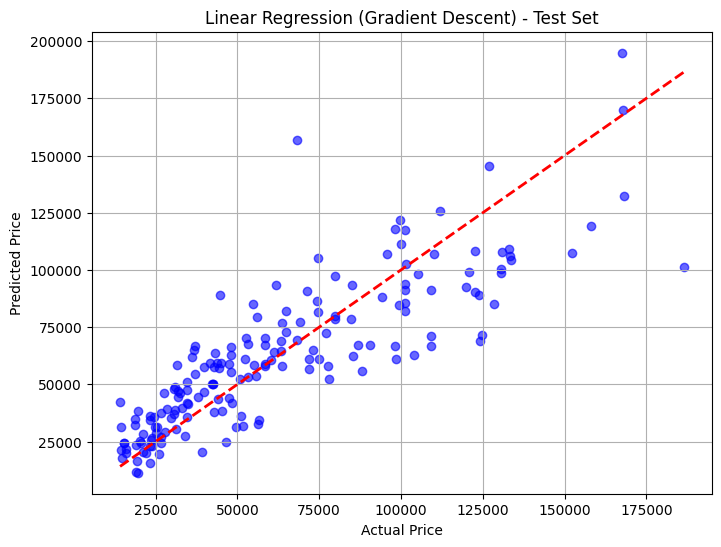

Train -> MSE: 403406207.44, RMSE: 20084.97, R²: 0.7088
Test  -> MSE: 423931615.69, RMSE: 20589.60, R²: 0.7162


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def factorize_dataframe(X_train_df, X_test_df):
    X_train_encoded = X_train_df.copy()
    X_test_encoded = X_test_df.copy()
    
    for col in X_train_encoded.select_dtypes(include='object').columns:
        X_train_encoded[col], uniques = pd.factorize(X_train_encoded[col])
        X_test_encoded[col] = X_test_encoded[col].map(
            lambda x: np.where(uniques == x)[0][0] if x in uniques else -1
        )
    return X_train_encoded, X_test_encoded


def standardize_features(X_train_df, X_test_df):
    X_mean = X_train_df.mean(axis=0)
    X_std = X_train_df.std(axis=0).replace(0,1)   
    X_train_scaled = (X_train_df - X_mean) / X_std
    X_test_scaled = (X_test_df - X_mean) / X_std
    return X_train_scaled.values.astype(float), X_test_scaled.values.astype(float)

 
def linear_regression_gd(X_train, y_train, X_test, y_test, learning_rate=0.01, n_iterations=50000):
    
    X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    
    
    theta = np.zeros(X_train_b.shape[1])
    m = len(y_train)
    
    
    for i in range(n_iterations):
        y_pred_train = X_train_b.dot(theta)
        error = y_pred_train - y_train
        gradients = 2/m * X_train_b.T.dot(error)
        theta -= learning_rate * gradients
    
    
    y_pred_train = X_train_b.dot(theta)
    y_pred_test = X_test_b.dot(theta)
    
    
    def compute_metrics(y_true, y_pred):
        mse = np.mean((y_true - y_pred)**2)
        rmse = np.sqrt(mse)
        r2 = 1 - np.sum((y_true - y_pred)**2)/np.sum((y_true - np.mean(y_true))**2)
        return mse, rmse, r2
    
    train_metrics = compute_metrics(y_train, y_pred_train)
    test_metrics = compute_metrics(y_test, y_pred_test)
    
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', linewidth=2)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Linear Regression (Gradient Descent) - Test Set")
    plt.grid(True)
    plt.show()
    
    return theta, train_metrics, test_metrics


X_train_enc, X_test_enc = factorize_dataframe(X_train, X_test)


X_train_scaled, X_test_scaled = standardize_features(X_train_enc, X_test_enc)


theta, train_metrics, test_metrics = linear_regression_gd(
    X_train_scaled, y_train.values.astype(float),
    X_test_scaled, y_test.values.astype(float),
    learning_rate=0.01,
    n_iterations=50000
)


print("Train -> MSE: {:.2f}, RMSE: {:.2f}, R²: {:.4f}".format(*train_metrics))
print("Test  -> MSE: {:.2f}, RMSE: {:.2f}, R²: {:.4f}".format(*test_metrics))


In [92]:
import numpy as np
import pandas as pd


def factorize_dataframe(X_train, X_test):
    X_train_df = X_train.copy()
    X_test_df = X_test.copy()
    
    for col in X_train_df.select_dtypes(include='object').columns:
        X_train_df[col], uniques = pd.factorize(X_train_df[col])
        X_test_df[col] = X_test_df[col].map(
            lambda x: np.where(uniques == x)[0][0] if x in uniques else -1
        )
    return X_train_df, X_test_df

X_train_enc, X_test_enc = factorize_dataframe(X_train, X_test)


X_train_arr = X_train_enc.values.astype(float)
X_test_arr = X_test_enc.values.astype(float)
y_train_arr = y_train.values.reshape(-1, 1)
y_test_arr = y_test.values.reshape(-1, 1)


X_mean = X_train_arr.mean(axis=0)
X_std = X_train_arr.std(axis=0)
X_train_scaled = (X_train_arr - X_mean) / X_std
X_test_scaled = (X_test_arr - X_mean) / X_std

X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]


def ridge_regression(X, y, lam=1.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0   
    theta = np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y
    return theta


ridge_lambda = 10
theta_ridge = ridge_regression(X_train_b, y_train_arr, lam=ridge_lambda)


y_pred_ridge = X_test_b @ theta_ridge


def lasso_regression(X, y, lam=0.1, lr=0.001, epochs=5000):
    m, n = X.shape
    theta = np.zeros((n, 1))
    for epoch in range(epochs):
        y_pred = X @ theta
        gradient = (2/m) * (X.T @ (y_pred - y)) + lam * np.sign(theta)
        gradient[0] -= lam * np.sign(theta[0])   
        theta -= lr * gradient
    return theta

lasso_lambda = 0.1
theta_lasso = lasso_regression(X_train_b, y_train_arr, lam=lasso_lambda)

y_pred_lasso = X_test_b @ theta_lasso

 
def regression_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = 1 - mse / np.var(y_true)
    return mse, rmse, r2

ridge_mse, ridge_rmse, ridge_r2 = regression_metrics(y_test_arr, y_pred_ridge)
lasso_mse, lasso_rmse, lasso_r2 = regression_metrics(y_test_arr, y_pred_lasso)

print(f"Ridge Regression -> MSE: {ridge_mse:.2f}, RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.4f}")
print(f"Lasso Regression -> MSE: {lasso_mse:.2f}, RMSE: {lasso_rmse:.2f}, R²: {lasso_r2:.4f}")


Ridge Regression -> MSE: 422976281.83, RMSE: 20566.39, R²: 0.7169
Lasso Regression -> MSE: 423642598.49, RMSE: 20582.58, R²: 0.7164
